# Monte Carlo Nullpoint Approach - Code Description

This is the central code for looking at nullpoints under a Jupyter Notebooks framework

This is the python script for replicating the Bi,Spencer 2D stabilization technique with the intention of varying TI for Eq.3 to observe the TI related nullpoint - this code has the potential to look at a histogram for each TI value or to look at the standard deviation across the population for a range of TI values

# Import Libraries

In [215]:
#Preparing all libraries
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
from scipy.optimize import curve_fit
from scipy.linalg import svd
from scipy.stats import trim_mean
import addcopyfighandler
import statistics
import math
import time
from tqdm import trange
from matplotlib import cm
import sklearn
from sklearn.cluster import KMeans
import colorsys
from datetime import date
import pickle

#New import: Set-ExecutionPolicy -ExecutionPolicy RemoteSigned -Scope Process
#Followed by: .venv\scripts\activate

# Set Options

In [216]:
#Plotting Related Options
histPlot = False        #Plots the parameter values for all iterations at each TI - one plot per iteration
stdPlot = True              #Plots the standard deviation of each parameter per TI
CN_estParams = False               #Plots the condition numbers per TI
denPlot = False              #Plot all recreated estimated signals against the true signal 
denPlotNoise = False         #Plots all noisy signals against the true data for comparison

#Process Related Options
dModel = True               #This option enables for using the d1 and d2 based model
bothTI = True               #Ensures that the code looks at both nullpoints rather than just the first one
onlyT1 = False            #Ignores the backbone if selected
intEnds = True
if onlyT1:
    assert(not bothTI)
randStart = False            #Enables the multistart option for curve_fit

load_results = True
load_file = "runInfo_10Jan23"

# Initialize Parameters and Arrays

In [217]:
#Assumed echo time points
TE_series = np.linspace(8, 512, 64) #ms units
assert(TE_series[-1] == 512)
assert(np.mean(np.diff(TE_series))==8)

#Parameters that dictate process related features
iterCount = 500 #number of iterations that curveFit is applied
SNR = 1000
noiseSigma = 1/SNR

#Curve Fit Trials - how many times do we run curve_fit before we take a parameter fit solution
if randStart:
    randStart_trials = 10
else:
    randStart_trials = 1

######All Fixed parameters for code
#Parameters held constant
c1 = 0.4
c2 = 0.6 #0.5
T21 = 45
T22 = 100
T11 = 600
T12 = 1200

initParams = np.array([T11, T12, c1, c2, T21, T22])

#Bound used during NLLS to constrain the upper bound on T2 values
T2_bound = 1000

#Zoom Fits range - used for plots
rad = 15 #standard unit radius around the zoom fits

#Information determing TI range
genResolution = 5 #30
nullResolution = 0.5
nullRadius = 10  #20

#Preparing TI array to loop through
TI1star = np.log(2)*T11
TI2star = np.log(2)*T12

#TI array bounds
TI_lowBound = TI1star*2//3
if bothTI:
    TI_highBound = TI2star*4//3
else:
    TI_highBound = np.mean([TI1star,TI2star])

standard_array = np.arange(-nullRadius,nullRadius+0.01,nullResolution)
if intEnds:
    TI1_array = np.floor(TI1star) + standard_array
    TI2_array = np.floor(TI2star) + standard_array
else:
    TI1_array = TI1star + standard_array
    TI2_array = TI2star + standard_array

gen_array = np.arange(TI_lowBound, TI_highBound, genResolution)

if bothTI:
    TI_array = np.concatenate((gen_array, TI1_array, TI2_array))
else:
    if onlyT1:
        TI_array = TI1_array
    else:
        TI_array = np.concatenate((gen_array, TI1_array))
TI_array = np.unique(TI_array)
TI_array.sort()

#Initializing all the storage matrices
#Storing all strings associated with titles
MonoTitle = ['d', 'T2']
ParamTitle_4p = [r'$d_1$', r'$d_2$', r'$T_{21}$', r'$T_{22}$']
ParamTitle_6p = ['T11','T12','c1','c2','T21','T22']

#List estimated Param names
if dModel:
    estParams = ParamTitle_4p
else:
    estParams = ParamTitle_6p[2:]

round_Params = [round(num, 2) for num in initParams]
pList = ', '.join(str(x) for x in round_Params)
pTitleList = ', '.join(x for x in ParamTitle_6p) #Builds the list of parametes used to generate the original data

if dModel:
    fitType = "4p in 4p eqn"
else:
    fitType = "4p in 6p eqn"

##################### Important for Naming
date = date.today()
day = date.strftime('%d')
month = date.strftime('%B')[0:3]
year = date.strftime('%y')

# Initialize Zeroed Arrays

In [218]:
#Initializing where all parameter values are stored
paramStore_2E = np.zeros([np.size(TI_array), iterCount, np.size(estParams)])
paramStore_1E = np.zeros([np.size(TI_array), iterCount, np.size(MonoTitle)])

#Storing all the estimated signals for each iteration and TI array
noiseSigStore = np.zeros([np.size(TI_array), iterCount, np.size(TE_series)])
sigStore_2E = np.zeros([np.size(TI_array), iterCount, np.size(TE_series)])
sigStore_1E = np.zeros([np.size(TI_array), iterCount, np.size(TE_series)])

#All error related matrices
RSS_Noise_Store_2E = np.zeros([np.size(TI_array),iterCount])
RSS_Noise_Store_1E = np.zeros([np.size(TI_array),iterCount])

#Count Rulebreakers
numRuleBreak = np.zeros((np.size(TI_array),2))

# Define Functions

In [219]:
#Defining the function of interest
def S_biX_6p(TE, TI, T11, T12, c1, c2, T21, T22):
    exp1 = c1*(1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    exp2 = c2*(1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    return exp1 + exp2

def S_biX_4p(TE, d1, d2, T21, T22):
    exp1 = d1*np.exp(-TE/T21)
    exp2 = d2*np.exp(-TE/T22)
    return exp1 + exp2

#Defining the monoExp function of interest
def S_moX_2p(TE, d, T2):
    return d*np.exp(-TE/T2)

#Function for calculating the d coeficient for a TI, c, T1 collection
def d_value(TI,c,T1):
    return c*(1-2*np.exp(-TI/T1))

def Jacobian_6p(TE, TI, T11, T12, c1, c2, T21, T22, TI_rescale = 1, TE_rescale = 1):
    [TE, T21, T22] = np.array([TE, T21, T22], dtype = 'object')/TE_rescale
    [TI, T11, T12] = np.array([TI, T11, T12], dtype = 'object')/TI_rescale
    #Returns the Jacobian of our 6 parameter, 2D problem
    dc1 = (1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    dc2 = (1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    dT11 = (-2*c1*TI/T11**2)*np.exp(-(TI/T11 + TE/T21))
    dT12 = (-2*c2*TI/T12**2)*np.exp(-(TI/T12 + TE/T22))
    dT21 = (c1*TE/T21**2)*(1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    dT22 = (c2*TE/T22**2)*(1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    
    jacobian = np.stack((dT11, dT12, dc1, dc2, dT21, dT22), axis = -1)
    return jacobian

def Jacobian_4p(TE, d1, d2, T21, T22, TE_rescale = 1):
    [TE, T21, T22] = np.array([TE, T21, T22], dtype = 'object')/TE_rescale
    #Returns the Jacobian of our 4 parameter, 2D problem
    dd1 = np.exp(-TE/T21)
    dd2 = np.exp(-TE/T22)
    dT21 = (d1*TE/T21**2)*np.exp(-TE/T21)
    dT22 = (d2*TE/T22**2)*np.exp(-TE/T22)
    
    jacobian = np.stack((dd1, dd2, dT21, dT22), axis = -1)
    return jacobian

def check_param_order(popt):
    #Reshaping of array to ensure that the parameter pairs all end up in the appropriate place - ensures that T22 > T21
    if (popt[-1] < popt[-2]): #We want by convention to make sure that T21 is <= T22
        for pi in range(np.size(popt)//2):
            p_hold = popt[2*pi]
            popt[2*pi] = popt[2*pi+1]
            popt[2*pi+1] = p_hold
    return popt

def add_noise(data,SNR):
    #returns a noised vector of data using the SNR given
    sigma = 1/SNR #np.max(np.abs(data))/SNR
    noise = np.random.normal(0,sigma,data.shape)
    noised_data = data + noise
    return noised_data

def _get_colors(num_colors):
    colors=[]
    for i in np.arange(0., 360., 360. / num_colors):
        hue = i/360.
        lightness = (50 + np.random.rand() * 10)/100.
        saturation = (90 + np.random.rand() * 10)/100.
        colors.append(colorsys.hls_to_rgb(hue, lightness, saturation))
    return colors

# Build Curve Fitting Dataset

In [220]:
if not load_results:
    #Looping through all TI values in the TI_array
    for k in trange(np.size(TI_array)):

        TI = TI_array[k]

        true_d1 = d_value(TI, c1, T11)
        true_d2 = d_value(TI, c2, T12)

        realParams_4p = np.array([true_d1, true_d2, T21, T22])

        realParams = np.array([c1,c2,T21,T22])

        trueDat_4p = S_biX_4p(TE_series, *realParams_4p)
        trueDat = S_biX_6p(TE_series, TI, T11, T12, c1, c2, T21, T22)

        assert(np.allclose(trueDat,trueDat_4p))
            
        brokenRules_2E = 0
        brokenRules_1E = 0

        for i in range(iterCount):

            #Determining the noise and add noise to data
            noiseDat = add_noise(trueDat,SNR)

            noiseSigStore[k,i,:] = noiseDat

            #This should be compared to the lowest RSS to noise
            paramTrials_2E = np.zeros((randStart_trials, np.size(estParams)))
            paramTrials_1E = np.zeros((randStart_trials, np.size(MonoTitle)))
            RSS_trials_2E = np.ones(randStart_trials)*np.inf
            RSS_trials_1E = np.ones(randStart_trials)*np.inf

            for tri in range(randStart_trials):
                
                #Running all the biexponential fits
                try:
                    ub = (1,1,T2_bound,T2_bound)

                    if dModel:
                        lb = (-1,-1,0,0)
                        if randStart:
                            init_p = tuple(np.add(np.subtract(ub,lb)*np.random.uniform(0,1,np.size(lb)),lb))
                        else:
                            init_p = realParams_4p

                        popt_2E, pcov_2E = curve_fit(lambda t_dat,p1,p2,p3,p4 : S_biX_4p(t_dat,p1,p2,p3,p4), TE_series, noiseDat, p0 = init_p, bounds = [lb,ub], method = 'trf', maxfev = 1500)
                        popt_2E = check_param_order(popt_2E)
                        est_Sig_2E = S_biX_4p(TE_series, *popt_2E)
                    
                    else:
                        lb = (0,0,0,0)
                        if randStart:
                            init_p = tuple(np.add(np.subtract(ub,lb)*np.random.uniform(0,1,np.size(lb)),lb))
                        else:
                            init_p = realParams
                        
                        popt_2E, pcov_2E = curve_fit(lambda t_dat,p1,p2,p3,p4 : S_biX_6p(t_dat,TI,T11,T12,p1,p2,p3,p4), TE_series, noiseDat, p0 = init_p, bounds = [lb,ub], method = 'trf', maxfev = 1500)
                        popt_2E = check_param_order(popt_2E)
                        est_Sig_2E = S_biX_6p(TE_series,TI,T11,T12,*popt_2E)
                    
                    paramTrials_2E[tri,:] = popt_2E
                    RSS_trials_2E[tri] = np.sum((noiseDat - est_Sig_2E)**2)

                except Exception as e:
                    print("Biexponential")
                    print(e)
                    brokenRules_2E += 1
                    continue

                #Running all the monoexponential fits
                try:
                    lb = (-1,0)
                    ub = (1,T2_bound)
                    if randStart:
                        init_p = tuple(np.add(np.subtract(ub,lb)*np.random.uniform(0,1,np.size(lb)),lb))
                    else:
                        init_p = ((true_d1 + true_d2)/2 , (T21 + T22)/2)

                    popt_1E, pcov_1E = curve_fit(lambda t_dat,p1,p2 : S_moX_2p(t_dat,p1,p2), TE_series, noiseDat, p0 = init_p, bounds = [lb,ub], method = 'trf', maxfev = 1500)
                    paramTrials_1E[tri,:] = popt_1E
                    est_Sig_1E = S_moX_2p(TE_series,*popt_1E)
                    RSS_trials_1E[tri] = np.sum((noiseDat - est_Sig_1E)**2)

                except Exception as e:
                    print("Monoexponential")
                    print(e)
                    brokenRules_1E += 1
                    continue

            #Identify the index of the lowest RSS
            minRSS_2E_index = np.argmin(RSS_trials_2E)
            minRSS_1E_index = np.argmin(RSS_trials_1E)

            #This step prevents rewriting the code anymore than I already have - sets the minimum trial as the optimal parameters
            popt_2E = paramTrials_2E[minRSS_2E_index,:]
            popt_1E = paramTrials_1E[minRSS_1E_index,:]

            paramStore_2E[k,i,:] = popt_2E
            paramStore_1E[k,i,:] = popt_1E

            #Calculate Residual Sum of Squares (RSS) of 2E
            if dModel:
                est_Sig_2E = S_biX_4p(TE_series, *popt_2E)
            else:
                est_Sig_2E = S_biX_6p(TE_series,TI,T11,T12,*popt_2E)
            RSS_Noise_Store_2E[k,i] = np.sum((noiseDat - est_Sig_2E)**2)
            sigStore_2E[k,i,:] = est_Sig_2E

            #Calculate Residual Sum of Squares (RSS) of 1E
            est_Sig_1E = S_moX_2p(TE_series,*popt_1E)
            RSS_Noise_Store_1E[k,i] = np.sum((noiseDat - est_Sig_1E)**2)
            sigStore_1E[k,i,:] = est_Sig_1E


        numRuleBreak[k,0] = brokenRules_2E
        numRuleBreak[k,1] = brokenRules_1E


### Save/Load Results

In [221]:
if not load_results:
    runInfo = {
        'dmodel': dModel,
        'SNR': SNR,
        'iter_count': iterCount,
        'randStart_trials': randStart_trials,
        'initParams': initParams,
        'TE': TE_series,
        'TI': TI_array,
        'TI1_array': TI1_array,
        'TI2_array': TI2_array,
        'genRes': genResolution,
        'nullRes': nullResolution,
        'nullRad': nullRadius,

        'pEst_2E': paramStore_2E,
        'pEst_1E': paramStore_1E,

        'RSS_2E': RSS_Noise_Store_2E,
        'RSS_1E': RSS_Noise_Store_1E
    }

    f = open(f'MC_Data//MCfit_SNR{SNR}_iters{iterCount}_' + day + month + year +'.pkl','wb')
    pickle.dump(runInfo,f)
    f.close()
else:
    with open('MC_Data//' + load_file + '.pkl', 'rb') as handle:
        dict = pickle.load(handle)

    dModel = dict['dmodel']
    SNR = dict['SNR']
    iter_count = dict['iter_count']
    randStart_trials = dict['randStart_trials']
    initParams = dict['initParams']
    TI1star = np.log(2)*initParams[0]
    TI2star = np.log(2)*initParams[1]
    TE_series = dict['TE']
    TI_array = dict['TI']
    TI1_array = dict['TI1_array']
    TI2_array = dict['TI2_array']
    genRes = dict['genRes']
    nullRad = dict['nullRad']
    nullRes = dict['nullRes']

    paramStore_2E = dict['pEst_2E']
    paramStore_1E = dict['pEst_1E']

    RSS_Noise_Store_2E = dict["RSS_2E"]
    RSS_Noise_Store_1E = dict['RSS_1E']
    
    handle.close()

In [222]:
##### Details - general title

details = str('\nTI1* = ' + str(round(TI1star,2)) + ' : TI2* = ' + str(round(TI2star,2)) +" :: SNR = " + str(SNR) + " :: Iter  = " + str(iterCount) +
            '\nParams (' + pTitleList + ') = ' + '('+ pList + ')' +
            '\n' +r'\alpha Radius = ' + str(nullRadius) + f':: TI_range = {TI_array[0]}, {TI_array[-1]} :: #TI = {len(TI_array)} :: Starts {randStart_trials}'+
            '\n' + fitType)

# Plotting

### Histograms of Parameters

##### Histogram of Direct Parameters

In [223]:
if histPlot:
    for k in range(paramStore_2E.shape[0]):
        paramData = paramStore_2E[k,:,:].copy()
        fig, ax = plt.subplots(1,2, figsize=(9.5,5.5), tight_layout=True)
        fig.suptitle("Parameter Histogram" + details)

        TI = TI_array[k]

        if dModel:
            true_d1 = d_value(TI, c1, T11)
            true_d2 = d_value(TI, c2, T12)

            plotParams = (true_d1, true_d2, T21, T22)
        else:
            plotParams = realParams
        
        for ii in range(2):
            #Construct a nice figure of each of the two 
            ax[ii].hist(x=paramData[:,2*ii], bins=20, color='b', label = estParams[2*ii], alpha = 0.7)
            ax[ii].hist(x=paramData[:,2*ii+1], bins=20, color='g', label = estParams[2*ii+1], alpha = 0.7)
            ax[ii].set_xlabel('Param Value')
            ax[ii].set_ylabel('Count')
            ax[ii].axvline(x=plotParams[2*ii], linewidth=1, label= 'True ' + estParams[2*ii], color='b')
            ax[ii].axvline(x=plotParams[2*ii+1], linewidth=1, label= 'True ' + estParams[2*ii+1], color='g')
            ax[ii].axvline(x=np.mean(paramData[:,2*ii]), linewidth=1, label= 'Avg ' + estParams[2*ii], color='b', ls = "--")
            ax[ii].axvline(x=np.mean(paramData[:,2*ii+1]), linewidth=1, label= 'Avg ' + estParams[2*ii+1], color='g', ls = "--")
            ax[ii].legend()
            ax[ii].set_title('Parameter Histogram Comparison' + 
                        '\n'+ r'$\alpha_1$'+ ' = ' + "{:.3f} :: ".format(TI/TI1star) + r'$\alpha_2$'+ ' = ' + "{:.3f} ".format(TI/TI2star) + ' :: TI = ' + str(round(TI,2)) +
                        '\nTrue ' + estParams[2*ii] + '=' + str(round(plotParams[2*ii],2)) + ' :: ' 
                        'True ' + estParams[2*ii+1] + '=' + str(round(plotParams[2*ii+1],2)))
        plt.show()

Far Away TI Value = 302.0
Null Point TI Value = 416.0


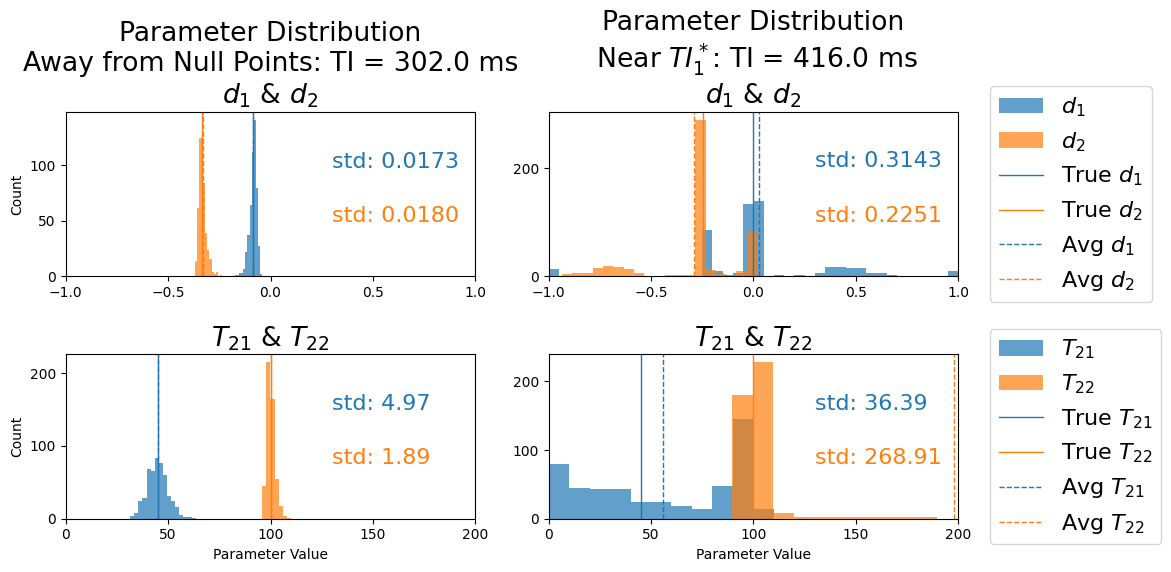

In [224]:
fig, ax = plt.subplots(2,2, figsize=(12,6), tight_layout=True)
# fig.suptitle("Parameter Histogram" + details)
plt.rc('font', size = 16)

index = np.argmin((TI_array-300)**2)
paramData = paramStore_2E[index,:,:].copy()
TI = TI_array[index]
print(f'Far Away TI Value = {TI}')
true_d1 = d_value(TI, c1, T11)
true_d2 = d_value(TI, c2, T12)
plotParams = (true_d1, true_d2, T21, T22)

for ii in range(2):
    #Construct a nice figure of each of the two 
    if ii == 0:
        binwidth = 0.01
    else:
        binwidth = 2
    ax[ii,0].hist(x=paramData[:,2*ii], bins=np.arange(min(paramData[:,2*ii]), max(paramData[:,2*ii]) + binwidth, binwidth), color='#1f77b4', label = estParams[2*ii], alpha = 0.7)
    ax[ii,0].hist(x=paramData[:,2*ii+1], bins=np.arange(min(paramData[:,2*ii+1]), max(paramData[:,2*ii+1]) + binwidth, binwidth), color='#ff7f0e', label = estParams[2*ii+1], alpha = 0.7)
    # ax[ii,0].set_xlabel('Parameter Value')
    ax[ii,0].set_ylabel('Count')
    ax[ii,0].axvline(x=plotParams[2*ii], linewidth=1, label= 'True ' + estParams[2*ii], color='#1f77b4')
    ax[ii,0].axvline(x=plotParams[2*ii+1], linewidth=1, label= 'True ' + estParams[2*ii+1], color='#ff7f0e')
    ax[ii,0].axvline(x=np.mean(paramData[:,2*ii]), linewidth=1, label= 'Avg ' + estParams[2*ii], color='#1f77b4', ls = "--")
    ax[ii,0].axvline(x=np.mean(paramData[:,2*ii+1]), linewidth=1, label= 'Avg ' + estParams[2*ii+1], color='#ff7f0e', ls = "--")
    # ax[ii,0].legend()
    ymin, ymax = ax[ii,0].get_ylim()
    yup = ymin+(ymax-ymin)*2//3
    ydn = ymin+(ymax-ymin)*1//3
    if ii == 0:
        ax[ii,0].set_title(f'Parameter Distribution\nAway from Null Points: TI = {TI} ms' + f'\n{estParams[2*ii]} & {estParams[2*ii+1]}')
        ax[ii,0].set_xlim([-1,1])
        ax[ii,0].text(0.3,yup, f"std: {np.std(paramData[:,2*ii]) :0.4f}", color = '#1f77b4')
        ax[ii,0].text(0.3,ydn, f"std: {np.std(paramData[:,2*ii+1]) :0.4f}", color = '#ff7f0e')
    else:
        ax[ii,0].set_title(f'{estParams[2*ii]} & {estParams[2*ii+1]}')
        ax[ii,0].set_xlabel('Parameter Value')
        ax[ii,0].set_xlim([0,200])
        ax[ii,0].text(130, yup, f"std: {np.std(paramData[:,2*ii]) :0.2f}", color = '#1f77b4')
        ax[ii,0].text(130, ydn, f"std: {np.std(paramData[:,2*ii+1]) :0.2f}", color = '#ff7f0e')


index = np.argmin((TI_array-TI1star)**2)
paramData = paramStore_2E[index,:,:].copy()
TI = TI_array[index]
print(f'Null Point TI Value = {TI}')
true_d1 = d_value(TI, c1, T11)
true_d2 = d_value(TI, c2, T12)
plotParams = (true_d1, true_d2, T21, T22)


for ii in range(2):
    #Construct a nice figure of each of the two 
    if ii == 0:
        binwidth = 0.05
    else:
        binwidth = 10
    ax[ii,1].hist(x=paramData[:,2*ii], bins=np.arange(min(paramData[:,2*ii]), max(paramData[:,2*ii]) + binwidth, binwidth), color='#1f77b4', label = estParams[2*ii], alpha = 0.7)
    ax[ii,1].hist(x=paramData[:,2*ii+1], bins=np.arange(min(paramData[:,2*ii+1]), max(paramData[:,2*ii+1]) + binwidth, binwidth), color='#ff7f0e', label = estParams[2*ii+1], alpha = 0.7)
    # ax[ii,1].set_xlabel('Param Value Value')
    # ax[ii,1].set_ylabel('Count')
    ax[ii,1].axvline(x=plotParams[2*ii], linewidth=1, label= 'True ' + estParams[2*ii], color='#1f77b4')
    ax[ii,1].axvline(x=plotParams[2*ii+1], linewidth=1, label= 'True ' + estParams[2*ii+1], color='#ff7f0e')
    ax[ii,1].axvline(x=np.mean(paramData[:,2*ii]), linewidth=1, label= 'Avg ' + estParams[2*ii], color='#1f77b4', ls = "--")
    ax[ii,1].axvline(x=np.mean(paramData[:,2*ii+1]), linewidth=1, label= 'Avg ' + estParams[2*ii+1], color='#ff7f0e', ls = "--")
    # handler, labeler = ax[i,0].get_legend_handles_labels()
    ax[ii,1].legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
    ymin, ymax = ax[ii,1].get_ylim()
    yup = ymin+(ymax-ymin)*2//3
    ydn = ymin+(ymax-ymin)*1//3
    if ii == 0:
        ax[ii,1].set_title('Parameter Distribution\n' + r' Near $TI_1^*$' + f': TI = {TI} ms\n{estParams[2*ii]} & {estParams[2*ii+1]}')
        ax[ii,1].set_xlim([-1,1])
        ax[ii,1].text(0.3, yup, f"std: {np.std(paramData[:,2*ii]) :0.4f}", color = '#1f77b4')
        ax[ii,1].text(0.3, ydn, f"std: {np.std(paramData[:,2*ii+1]) :0.4f}", color = '#ff7f0e')
    else:
        ax[ii,1].set_title(f'{estParams[2*ii]} & {estParams[2*ii+1]}')
        ax[ii,1].set_xlabel('Parameter Value')
        ax[ii,1].set_xlim([0,200])
        ax[ii,1].text(130, yup, f"std: {np.std(paramData[:,2*ii]) :0.2f}", color = '#1f77b4')
        ax[ii,1].text(130, ydn, f"std: {np.std(paramData[:,2*ii+1]) :0.2f}", color = '#ff7f0e')
plt.show()

Far Away TI Value = 302.0
Null Point TI Value = 416.0
Null Point TI Value = 502.0


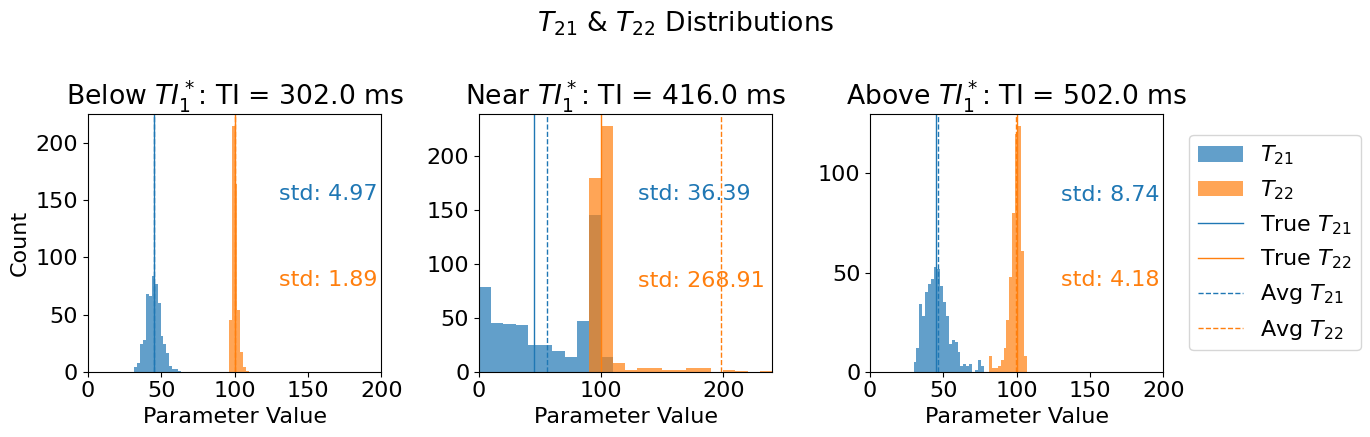

In [225]:
fig, ax = plt.subplots(1,3, figsize=(14,4.5), tight_layout=True)
# fig.suptitle("Parameter Histogram" + details)
plt.rc('font', size = 16)

fig.suptitle(f'{estParams[2*ii]} & {estParams[2*ii+1]} Distributions')

index = np.argmin((TI_array-300)**2)
paramData = paramStore_2E[index,:,:].copy()
TI = TI_array[index]
print(f'Far Away TI Value = {TI}')
true_d1 = d_value(TI, c1, T11)
true_d2 = d_value(TI, c2, T12)
plotParams = (true_d1, true_d2, T21, T22)

ii = 1
binwidth = 2
ax[0].hist(x=paramData[:,2*ii], bins=np.arange(min(paramData[:,2*ii]), max(paramData[:,2*ii]) + binwidth, binwidth), color='#1f77b4', label = estParams[2*ii], alpha = 0.7)
ax[0].hist(x=paramData[:,2*ii+1], bins=np.arange(min(paramData[:,2*ii+1]), max(paramData[:,2*ii+1]) + binwidth, binwidth), color='#ff7f0e', label = estParams[2*ii+1], alpha = 0.7)
# ax[ii,0].set_xlabel('Parameter Value')
ax[0].set_ylabel('Count')
ax[0].axvline(x=plotParams[2*ii], linewidth=1, label= 'True ' + estParams[2*ii], color='#1f77b4')
ax[0].axvline(x=plotParams[2*ii+1], linewidth=1, label= 'True ' + estParams[2*ii+1], color='#ff7f0e')
ax[0].axvline(x=np.mean(paramData[:,2*ii]), linewidth=1, label= 'Avg ' + estParams[2*ii], color='#1f77b4', ls = "--")
ax[0].axvline(x=np.mean(paramData[:,2*ii+1]), linewidth=1, label= 'Avg ' + estParams[2*ii+1], color='#ff7f0e', ls = "--")
ax[0].set_title(r'Below $TI_1^*$' + f': TI = {TI} ms')
# ax[ii,0].legend()
ymin, ymax = ax[0].get_ylim()
yup = ymin+(ymax-ymin)*2//3
ydn = ymin+(ymax-ymin)*1//3
# ax[0].set_title(f'{estParams[2*ii]} & {estParams[2*ii+1]}')
ax[0].set_xlabel('Parameter Value')
ax[0].set_xlim([0,200])
ax[0].text(130, yup, f"std: {np.std(paramData[:,2*ii]) :0.2f}", color = '#1f77b4')
ax[0].text(130, ydn, f"std: {np.std(paramData[:,2*ii+1]) :0.2f}", color = '#ff7f0e')


index = np.argmin((TI_array-TI1star)**2)
paramData = paramStore_2E[index,:,:].copy()
TI = TI_array[index]
print(f'Null Point TI Value = {TI}')
true_d1 = d_value(TI, c1, T11)
true_d2 = d_value(TI, c2, T12)
plotParams = (true_d1, true_d2, T21, T22)


ii = 1
binwidth = 10
ax[1].hist(x=paramData[:,2*ii], bins=np.arange(min(paramData[:,2*ii]), max(paramData[:,2*ii]) + binwidth, binwidth), color='#1f77b4', label = estParams[2*ii], alpha = 0.7)
ax[1].hist(x=paramData[:,2*ii+1], bins=np.arange(min(paramData[:,2*ii+1]), max(paramData[:,2*ii+1]) + binwidth, binwidth), color='#ff7f0e', label = estParams[2*ii+1], alpha = 0.7)
# ax[ii,1].set_xlabel('Param Value Value')
# ax[ii,1].set_ylabel('Count')
ax[1].axvline(x=plotParams[2*ii], linewidth=1, label= 'True ' + estParams[2*ii], color='#1f77b4')
ax[1].axvline(x=plotParams[2*ii+1], linewidth=1, label= 'True ' + estParams[2*ii+1], color='#ff7f0e')
ax[1].axvline(x=np.mean(paramData[:,2*ii]), linewidth=1, label= 'Avg ' + estParams[2*ii], color='#1f77b4', ls = "--")
ax[1].axvline(x=np.mean(paramData[:,2*ii+1]), linewidth=1, label= 'Avg ' + estParams[2*ii+1], color='#ff7f0e', ls = "--")
# handler, labeler = ax[i,0].get_legend_handles_labels()

ymin, ymax = ax[1].get_ylim()
yup = ymin+(ymax-ymin)*2//3
ydn = ymin+(ymax-ymin)*1//3
ax[1].set_title(r'Near $TI_1^*$' + f': TI = {TI} ms')
# ax[1].set_title(f'{estParams[2*ii]} & {estParams[2*ii+1]}')
ax[1].set_xlabel('Parameter Value')
ax[1].set_xlim([0,240])
ax[1].text(130, yup, f"std: {np.std(paramData[:,2*ii]) :0.2f}", color = '#1f77b4')
ax[1].text(130, ydn, f"std: {np.std(paramData[:,2*ii+1]) :0.2f}", color = '#ff7f0e')

index = np.argmin((TI_array-500)**2)
paramData = paramStore_2E[index,:,:].copy()
TI = TI_array[index]
print(f'Null Point TI Value = {TI}')
true_d1 = d_value(TI, c1, T11)
true_d2 = d_value(TI, c2, T12)
plotParams = (true_d1, true_d2, T21, T22)


ii = 1
binwidth = 2
ax[2].hist(x=paramData[:,2*ii], bins=np.arange(min(paramData[:,2*ii]), max(paramData[:,2*ii]) + binwidth, binwidth), color='#1f77b4', label = estParams[2*ii], alpha = 0.7)
ax[2].hist(x=paramData[:,2*ii+1], bins=np.arange(min(paramData[:,2*ii+1]), max(paramData[:,2*ii+1]) + binwidth, binwidth), color='#ff7f0e', label = estParams[2*ii+1], alpha = 0.7)
# ax[ii,1].set_xlabel('Param Value Value')
# ax[ii,1].set_ylabel('Count')
ax[2].axvline(x=plotParams[2*ii], linewidth=1, label= 'True ' + estParams[2*ii], color='#1f77b4')
ax[2].axvline(x=plotParams[2*ii+1], linewidth=1, label= 'True ' + estParams[2*ii+1], color='#ff7f0e')
ax[2].axvline(x=np.mean(paramData[:,2*ii]), linewidth=1, label= 'Avg ' + estParams[2*ii], color='#1f77b4', ls = "--")
ax[2].axvline(x=np.mean(paramData[:,2*ii+1]), linewidth=1, label= 'Avg ' + estParams[2*ii+1], color='#ff7f0e', ls = "--")
# handler, labeler = ax[i,0].get_legend_handles_labels()
ax[2].legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
ymin, ymax = ax[2].get_ylim()
yup = ymin+(ymax-ymin)*2//3
ydn = ymin+(ymax-ymin)*1//3
ax[2].set_title(r'Above $TI_1^*$' + f': TI = {TI} ms')
# ax[2].set_title(f'{estParams[2*ii]} & {estParams[2*ii+1]}')
ax[2].set_xlabel('Parameter Value')
ax[2].set_xlim([0,200])
ax[2].text(130, yup, f"std: {np.std(paramData[:,2*ii]) :0.2f}", color = '#1f77b4')
ax[2].text(130, ydn, f"std: {np.std(paramData[:,2*ii+1]) :0.2f}", color = '#ff7f0e')

ax[2].legend(loc='center left', bbox_to_anchor=(1.05, 0.5))

plt.show()

##### dModel Specific Parameter Histogram

In [226]:
if histPlot and dModel:
    for k in range(paramStore_2E.shape[0]):
        paramData = paramStore_2E[k,:,:].copy()
        fig, ax = plt.subplots(1,2, figsize=(9.5,5.5), tight_layout=True)
        fig.suptitle("Calculated Parameter Histogram" + details)

        estParamsTemp = ParamTitle_6p[2:np.size(ParamTitle_6p)]

        TI = TI_array[k]

        if TI==TI1star or TI==TI2star:
            fig.suptitle("Skipped nullpoint")
            continue

        paramData[:,0] = paramData[:,0]/(1-2*np.exp(-TI/T11)) #calculating all of the c1 values
        paramData[:,1] = paramData[:,1]/(1-2*np.exp(-TI/T12)) #calculating all of the c2 values
        
        for ii in range(2):
            #Construct a nice figure of each of the two 
            ax[ii].hist(x=paramData[:,2*ii], bins=20, color='b', label = estParamsTemp[2*ii], alpha = 0.7)
            ax[ii].hist(x=paramData[:,2*ii+1], bins=20, color='g', label = estParamsTemp[2*ii+1], alpha = 0.7)
            ax[ii].set_xlabel('Param Value')
            ax[ii].set_ylabel('Count')
            ax[ii].axvline(x=realParams[2*ii], linewidth=1, label= 'True ' + estParamsTemp[2*ii], color='b')
            ax[ii].axvline(x=realParams[2*ii+1], linewidth=1, label= 'True ' +estParamsTemp[2*ii+1], color='g')
            ax[ii].axvline(x=np.mean(paramData[:,2*ii]), linewidth=1, label= 'Avg ' + estParamsTemp[2*ii], color='b', ls = "--")
            ax[ii].axvline(x=np.mean(paramData[:,2*ii+1]), linewidth=1, label= 'Avg ' + estParamsTemp[2*ii+1], color='g', ls = "--")
            ax[ii].legend()
            ax[ii].set_title('Parameter Histogram Comparison' + 
                        '\n' + r'$\alpha_1$'+ ' = ' + "{:.3f} :: ".format(TI/TI1star) + r'$\alpha_2$'+ ' = ' + "{:.3f} ".format(TI/TI2star) + ' :: TI = ' + str(round(TI,2)) +
                        '\nTrue ' + estParamsTemp[2*ii] + '=' + str(round(realParams[2*ii],2)) + ' :: ' 
                        'True ' + estParamsTemp[2*ii+1] + '=' + str(round(realParams[2*ii+1],2)))
        plt.show()

### Signal Plots

##### Density Plot of Fitted Signals

In [227]:
if denPlot:
    for k in range(paramStore_2E.shape[0]):

        TI = TI_array[k]
        trueDat = S_biX_6p(TE_series, TI, T11, T12, c1, c2, T21, T22)

        fig, ax = plt.subplots(1,2, figsize=(10,8), tight_layout=True)

        fig.suptitle('Fit Visualization' + details + 
                        '\n' + r'$\alpha_1$'+ ' = ' + "{:.3f} :: ".format(TI/TI1star) + r'$\alpha_2$'+ ' = ' + "{:.3f} ".format(TI/TI2star) + ' :: TI = ' + str(round(TI,2)))
        
        for rep in range(iterCount):
            ax[0].plot(TE_series, sigStore_2E[k,rep,:], color='r', alpha = 0.5)
            ax[1].plot(TE_series, sigStore_1E[k,rep,:], color='r', alpha = 0.5)

        ax[0].plot(TE_series, trueDat, label = "True Data", color='k', alpha = 1)
        ax[1].plot(TE_series, trueDat, label = "True Data", color='k', alpha = 1)

        ax[0].set_xlabel("TE")
        ax[1].set_xlabel("TE")
        ax[0].set_ylabel("Signal")
        ax[1].set_ylabel("Signal")
        ax[0].set_title("Biexponential Fits")
        ax[1].set_title("Monoexponential Fits")

        plt.show()

##### Density Plot of Noisy Signals

In [228]:
if denPlotNoise:
    for k in range(paramStore_2E.shape[0]):

        TI = TI_array[k]
        trueDat = S_biX_6p(TE_series, TI, T11, T12, c1, c2, T21, T22)

        fig = plt.figure(figsize=(7,6), tight_layout=True)
        
        for rep in range(iterCount):
            plt.plot(TE_series, noiseSigStore[k,rep,:], color='r', alpha = 0.5)

        plt.plot(TE_series, trueDat, label = "True Data", color='k', alpha = 1)
        plt.xlabel("TE")
        plt.ylabel("Signal")
        plt.title("Noisy Signals" + details + 
                        '\n'+ r'$\alpha_1$'+ ' = ' + "{:.3f} :: ".format(TI/TI1star) + r'$\alpha_2$'+ ' = ' + "{:.3f} ".format(TI/TI2star) + ' :: TI = ' + str(round(TI,2)))


        plt.show()

##### D Parameter Mean Measure

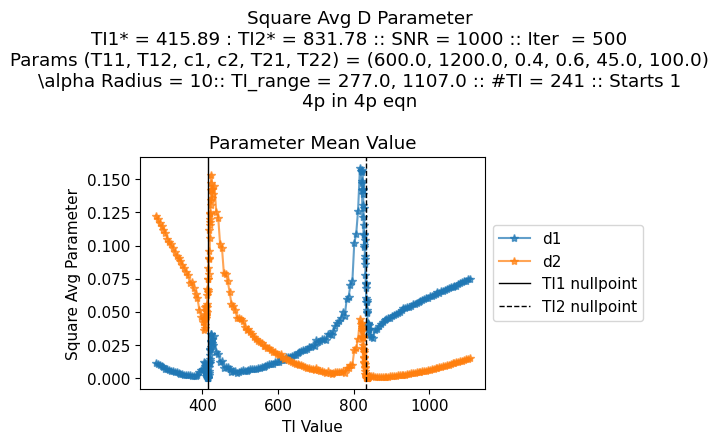

In [229]:
mean_param_2E = np.mean(paramStore_2E, axis = 1)
d1_zero = mean_param_2E[:,0]**2
d2_zero = mean_param_2E[:,1]**2

fig = plt.figure(figsize=(6,4.5), tight_layout=True)
plt.rc('font', size = 11)
fig.suptitle('Square Avg D Parameter' + details)
plt.plot(TI_array, d1_zero, label = 'd1', alpha = 0.7, marker = "*")
plt.plot(TI_array, d2_zero, label = 'd2', alpha = 0.7, marker = "*")
# ax[i].plot(TI_array,mono_std[:,i], label = MonoTitle[i], alpha = 0.7)
plt.axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
if bothTI:
    plt.axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
plt.xlabel('TI Value')
plt.ylabel('Square Avg Parameter')
plt.title('Parameter Mean Value')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

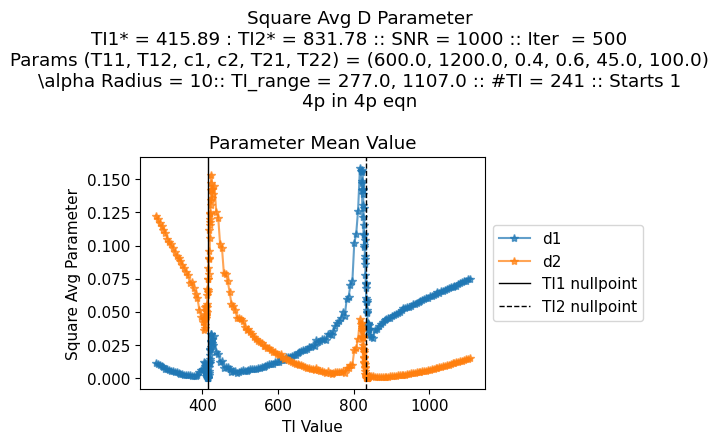

In [197]:
mean_param_2E = np.mean(paramStore_2E, axis = 1)
d1_zero = mean_param_2E[:,0]**2
d2_zero = mean_param_2E[:,1]**2

fig = plt.figure(figsize=(6,4.5), tight_layout=True)
plt.rc('font', size = 11)
fig.suptitle('Square Avg D Parameter' + details)
plt.plot(TI_array, d1_zero, label = 'd1', alpha = 0.7, marker = "*")
plt.plot(TI_array, d2_zero, label = 'd2', alpha = 0.7, marker = "*")
# ax[i].plot(TI_array,mono_std[:,i], label = MonoTitle[i], alpha = 0.7)
plt.axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
if bothTI:
    plt.axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
plt.xlabel('TI Value')
plt.ylabel('Square Avg Parameter')
plt.title('Parameter Mean Value')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Standard Deviation

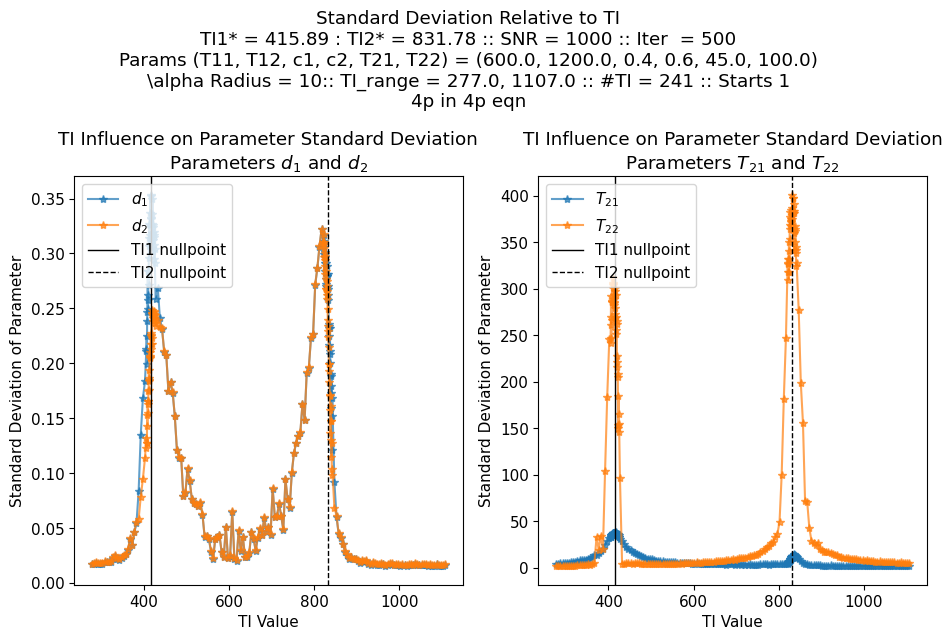

In [198]:
stdStore = np.std(paramStore_2E, axis = 1)
std2Store = np.var(paramStore_2E, axis = 1)**(1/2)
assert(np.all(np.isclose(stdStore,std2Store)))
mono_std = np.std(paramStore_1E, axis = 1)

if stdPlot:
    fig, ax = plt.subplots(1,2, figsize=(9.5,6.5), tight_layout=True)
    plt.rc('font', size = 11)
    fig.suptitle('Standard Deviation Relative to TI' + details)
    for i in range(2):
        ax[i].plot(TI_array,stdStore[:,2*i], label = estParams[2*i], alpha = 0.7, marker = "*")
        ax[i].plot(TI_array,stdStore[:,2*i+1], label = estParams[2*i+1], alpha = 0.7, marker = "*")
        # ax[i].plot(TI_array,mono_std[:,i], label = MonoTitle[i], alpha = 0.7)
        ax[i].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
        if bothTI:
            ax[i].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
        ax[i].set_xlabel('TI Value')
        ax[i].set_ylabel('Standard Deviation of Parameter')
        ax[i].set_title('TI Influence on Parameter Standard Deviation' + '\nParameters ' + estParams[2*i] + ' and ' + estParams[2*i+1])
        ax[i].legend()
    plt.show()

##### Official STD Figure

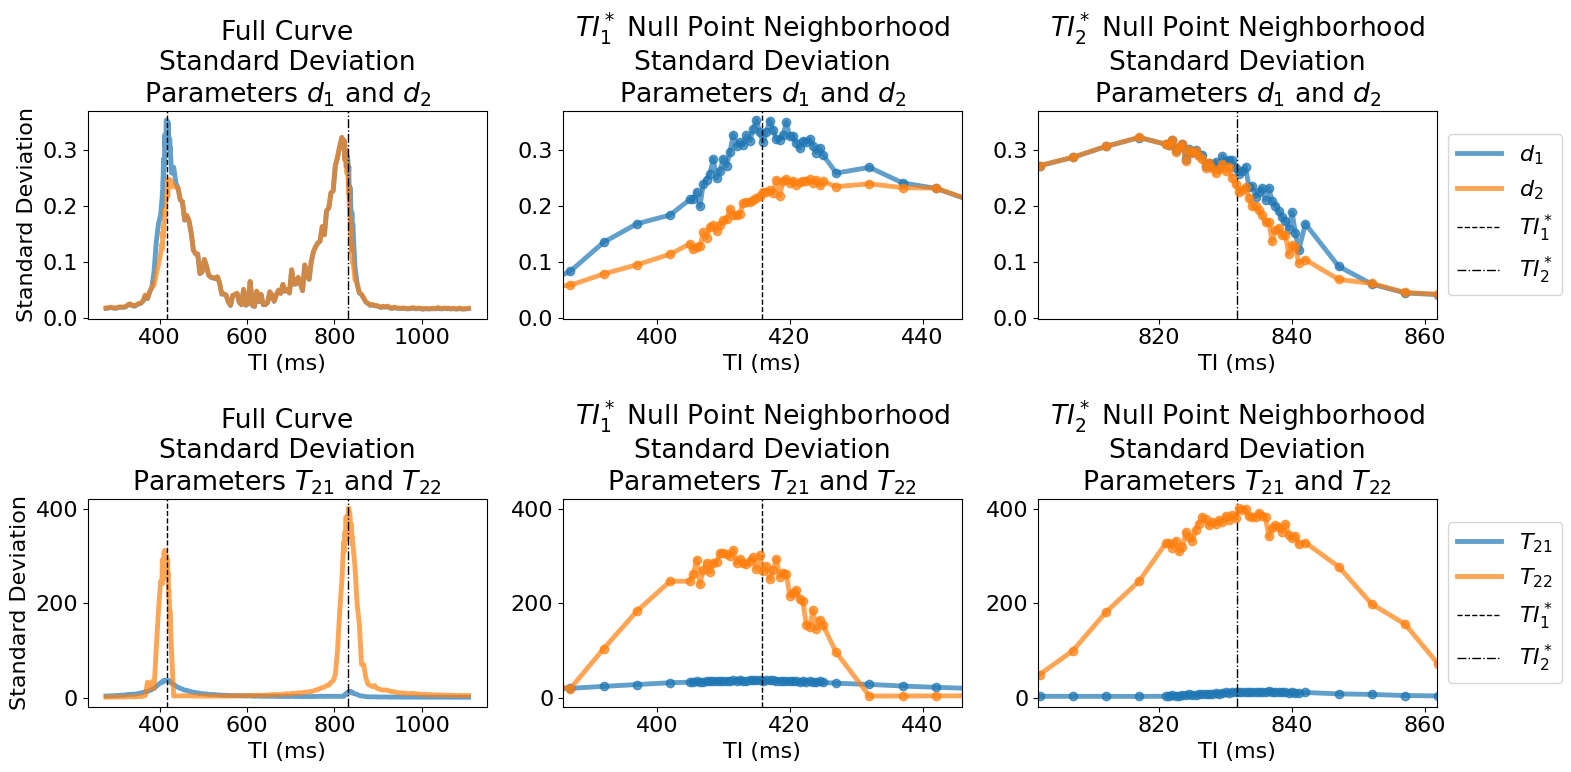

In [199]:

chosen_radius = 30
plt.rc('font', size = 16)
fig, ax = plt.subplots(2,3, figsize=(16,8), tight_layout=True)
for i in range(2):
    ax[i,0].plot(TI_array,stdStore[:,2*i], label = estParams[2*i], alpha = 0.7, linewidth = 3.5)
    ax[i,0].plot(TI_array,stdStore[:,2*i+1], label = estParams[2*i+1], alpha = 0.7, linewidth = 3.5)
    ax[i,0].axvline(x=TI1star, linewidth=1, label= r'$TI^*_1$', color='k', ls = '--')
    ax[i,0].axvline(x=TI2star, linewidth=1, label= r'$TI^*_2$', color='k', ls = '-.')
    ax[i,0].set_xlabel('TI (ms)')
    ax[i,0].set_ylabel('Standard Deviation')
    ax[i,0].set_title(r'Full Curve' + '\nStandard Deviation' + '\nParameters ' + estParams[2*i] + ' and ' + estParams[2*i+1])
    handler, labeler = ax[i,0].get_legend_handles_labels()

    a1 = ax[i,1].plot(TI_array,stdStore[:,2*i], label = estParams[2*i], alpha = 0.7, marker = 'o', linewidth = "3.5")
    ax[i,1].axvline(x=TI1star, linewidth=1, label= 'null point', color='k', ls = '--')
    ax[i,1].set_xlabel('TI (ms)')
    # ax[i,1].set_ylabel('Standard Deviation')
    ax[i,1].set_title(r'$TI^*_1$ Null Point Neighborhood' + '\nStandard Deviation' + '\nParameters ' + estParams[2*i] + ' and ' + estParams[2*i+1])
    ax[i,1].set_xlim([TI1star-chosen_radius, TI1star+chosen_radius])

    a2 = ax[i,2].plot(TI_array,stdStore[:,2*i], label = estParams[2*i], alpha = 0.7, marker = 'o', linewidth = "3.5")
    ax[i,2].axvline(x=TI2star, linewidth=1, label= 'null point', color='k', ls = '-.')
    ax[i,2].set_xlabel('TI (ms)')
    # ax[i,2].set_ylabel('Standard Deviation')
    ax[i,2].set_title(r'$TI^*_2$ Null Point Neighborhood' + '\nStandard Deviation' + '\nParameters ' + estParams[2*i] + ' and ' + estParams[2*i+1])
    ax[i,2].legend(handler, labeler, loc='center left', bbox_to_anchor=(1, 0.5))
    ax[i,2].set_xlim([TI2star-chosen_radius, TI2star+chosen_radius])
    # if i == 1:
    #     ax[i,1].set_ylabel(color = a1.get_color())
    #     ax[i,2].set_ylabel(color = a2.get_color())

    # else:
    ax[i,1].plot(TI_array,stdStore[:,2*i+1], label = estParams[2*i+1], alpha = 0.7, marker = 'o', linewidth = "3.5")
    ax[i,2].plot(TI_array,stdStore[:,2*i+1], label = estParams[2*i+1], alpha = 0.7, marker = 'o', linewidth = "3.5")
        
plt.show()

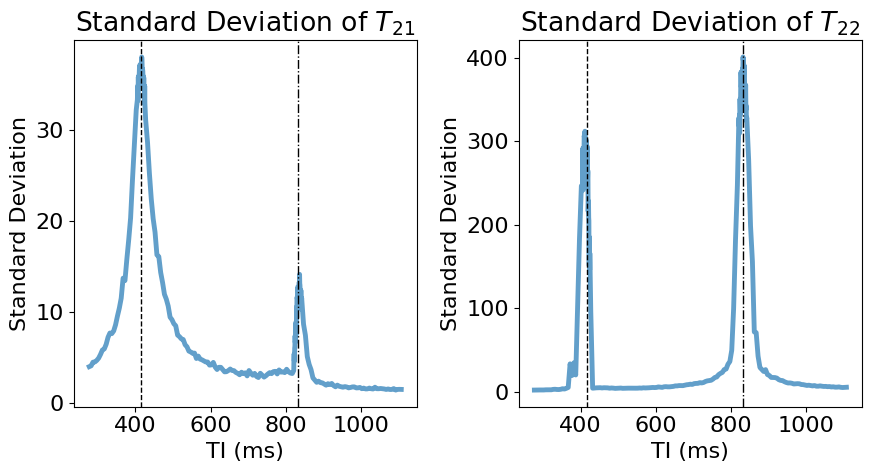

In [200]:

chosen_radius = 30
plt.rc('font', size = 16)
fig, ax = plt.subplots(1,2, figsize=(9,5), tight_layout=True)
for i in range(2):
    ax[i].plot(TI_array,stdStore[:,2+i], label = estParams[2*i], alpha = 0.7, linewidth = 3.5)
    # ax[i,0].plot(TI_array,stdStore[:,2*i+1], label = estParams[2*i+1], alpha = 0.7, linewidth = 3.5)
    ax[i].axvline(x=TI1star, linewidth=1, label= r'$TI^*_1$', color='k', ls = '--')
    ax[i].axvline(x=TI2star, linewidth=1, label= r'$TI^*_2$', color='k', ls = '-.')
    ax[i].set_xlabel('TI (ms)')
    ax[i].set_ylabel('Standard Deviation')
    ax[i].set_title('Standard Deviation of ' + estParams[2+i])
    # handler, labeler = ax[i,0].get_legend_handles_labels()
    # ax[i,2].legend(handler, labeler, loc='center left', bbox_to_anchor=(1, 0.5))

    # if i == 1:
    #     ax[i,1].set_ylabel(color = a1.get_color())
    #     ax[i,2].set_ylabel(color = a2.get_color())

    # else:
    # ax[i,1].plot(TI_array,stdStore[:,2*i+1], label = estParams[2*i+1], alpha = 0.7, marker = 'o', linewidth = "3.5")
    # ax[i,2].plot(TI_array,stdStore[:,2*i+1], label = estParams[2*i+1], alpha = 0.7, marker = 'o', linewidth = "3.5")
        
plt.show()

### Condition Number

##### Analytic Effective-Condition Number Plots

In [164]:
###Conditon Number using different Jacobians

nondimensional_option = True
if nondimensional_option:
    ND_addendum = "\nnondimensionalized"
else:
    ND_addendum = ""

reduced_6p = False
if reduced_6p:
    columns_kept = np.array([0,1,2,3,4,5])
    final_size = columns_kept.shape[0]
    CN_addendum = "\nclip T2s"
else:
    CN_addendum = ""

condition_6p_B = np.zeros((np.size(TI_array),1))
condition_6p_BTB = np.zeros((np.size(TI_array),1))

eigenBig_6p = np.zeros((np.size(TI_array),2))
eigenLil_6p = np.zeros((np.size(TI_array),2))

condition_6p_B_2x4subset = np.zeros((np.size(TI_array),2))
condition_6p_BTB_2x4subset = np.zeros((np.size(TI_array),2))

condition_6p_B_2subset = np.zeros((np.size(TI_array),3))
condition_6p_BTB_2subset = np.zeros((np.size(TI_array),3))

condition_4p_B = np.zeros((np.size(TI_array),1))
condition_4p_BTB = np.zeros((np.size(TI_array),1))

eigenBig_4p = np.zeros((np.size(TI_array),2))
eigenLil_4p = np.zeros((np.size(TI_array),2))

for iTI in range(np.size(TI_array)):

    TI = TI_array[iTI]

    if nondimensional_option:
        B_mat = Jacobian_6p(TE_series, TI, T11, T12, c1, c2, T21, T22, TE_rescale = np.max(TE_series), TI_rescale = np.max(TI_array))
    else:
        B_mat = Jacobian_6p(TE_series, TI, T11, T12, c1, c2, T21, T22)
    if reduced_6p:
        B_mat = B_mat[:,columns_kept]
        assert(B_mat.shape[-1] == final_size)
    _, B_svd, _ = np.linalg.svd(B_mat)
    eigenBig_6p[iTI,0] = B_svd[0]
    eigenLil_6p[iTI,0] = B_svd[-1]
    condition_6p_B[iTI] = np.linalg.cond(B_mat)
    covP = np.dot(B_mat.T,B_mat)
    _, B_svd, _ = np.linalg.svd(covP)
    eigenBig_6p[iTI,1] = B_svd[0]
    eigenLil_6p[iTI,1] = B_svd[-1]
    condition_6p_BTB[iTI] = np.linalg.cond(covP)

    condition_6p_B_2x4subset[iTI,0] = np.linalg.cond(B_mat[:,2:4])
    condition_6p_B_2x4subset[iTI,1] = np.linalg.cond(B_mat[:,[0,1,4,5]])

    condition_6p_BTB_2x4subset[iTI,0] = np.linalg.cond(np.dot(B_mat[:,2:4].T,B_mat[:,2:4]))
    condition_6p_BTB_2x4subset[iTI,1] = np.linalg.cond(np.dot(B_mat[:,[0,1,4,5]].T,B_mat[:,[0,1,4,5]]))

    condition_6p_B_2subset[iTI,0] = np.linalg.cond(B_mat[:,2:4])
    condition_6p_B_2subset[iTI,1] = np.linalg.cond(B_mat[:,0:2])
    condition_6p_B_2subset[iTI,2] = np.linalg.cond(B_mat[:,4:])

    condition_6p_BTB_2subset[iTI,0] = np.linalg.cond(np.dot(B_mat[:,2:4].T,B_mat[:,2:4]))
    condition_6p_BTB_2subset[iTI,1] = np.linalg.cond(np.dot(B_mat[:,0:2].T,B_mat[:,0:2]))
    condition_6p_BTB_2subset[iTI,2] = np.linalg.cond(np.dot(B_mat[:,4:].T,B_mat[:,4:]))

    
    d1 = d_value(TI,c1,T11)
    d2 = d_value(TI,c2,T12)
    if nondimensional_option:
        B_mat = Jacobian_4p(TE_series, d1, d2, T21, T22, TE_rescale = np.max(TE_series))
    else:
        B_mat = Jacobian_4p(TE_series, d1, d2, T21, T22)
    _, B_svd, _ = np.linalg.svd(B_mat)
    eigenBig_4p[iTI,0] = B_svd[0]
    eigenLil_4p[iTI,0] = B_svd[-1]
    condition_4p_B[iTI] = np.linalg.cond(B_mat)
    covP = np.dot(B_mat.T,B_mat)
    _, B_svd, _ = np.linalg.svd(covP)
    eigenBig_4p[iTI,1] = B_svd[0]
    eigenLil_4p[iTI,1] = B_svd[-1]
    condition_4p_BTB[iTI] = np.linalg.cond(covP)



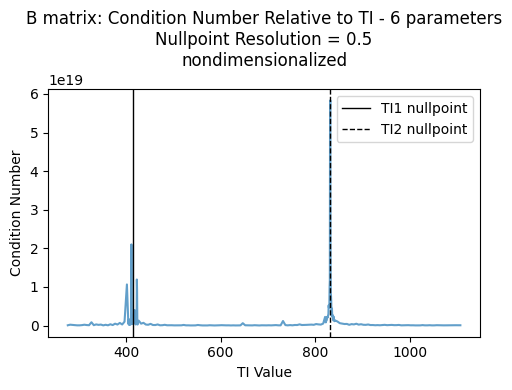

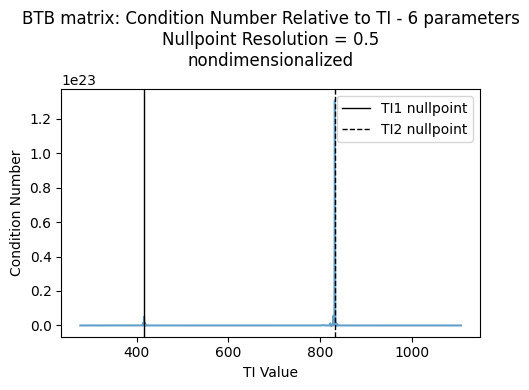

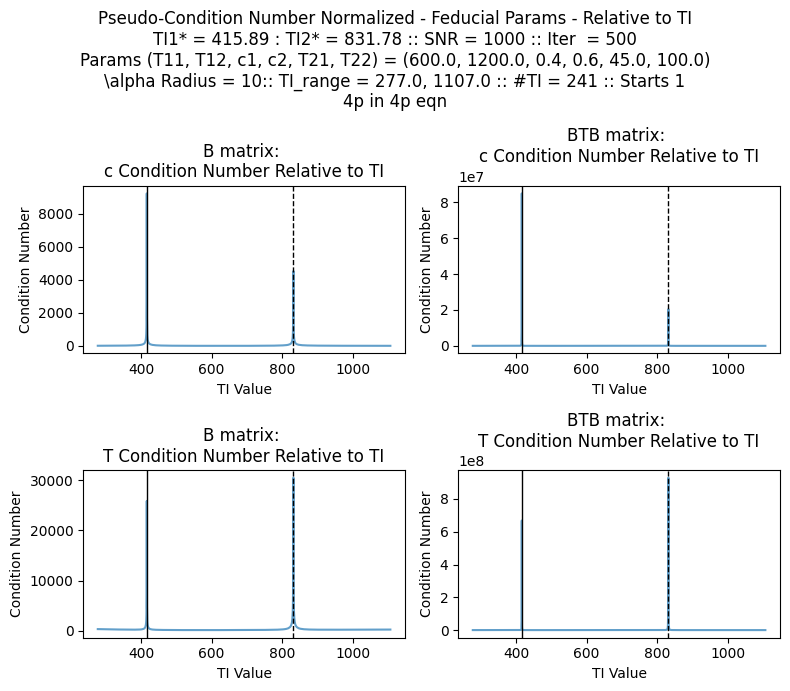

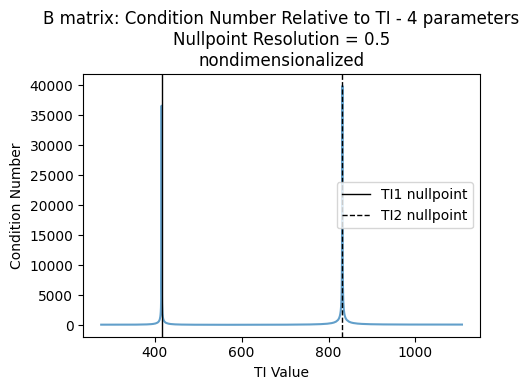

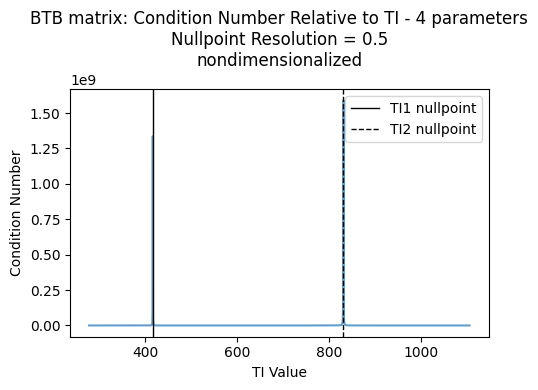

In [133]:
######### All figures
fig = plt.figure(1, figsize=(5,4), tight_layout=True)
plt.rc('font', size = 10)
plt.plot(TI_array, condition_6p_B, alpha = 0.7)
plt.axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
if bothTI:
    plt.axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
plt.xlabel('TI Value')
plt.ylabel('Condition Number')
plt.title('B matrix: Condition Number Relative to TI - 6 parameters'
            + '\nNullpoint Resolution = {:.1f}'.format(nullResolution) + CN_addendum + ND_addendum)
plt.legend()
plt.show()

fig = plt.figure(1, figsize=(5,4), tight_layout=True)
plt.plot(TI_array, condition_6p_BTB, alpha = 0.7)
plt.axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
if bothTI:
    plt.axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
plt.xlabel('TI Value')
plt.ylabel('Condition Number')
plt.title('BTB matrix: Condition Number Relative to TI - 6 parameters'
            + '\nNullpoint Resolution = {:.1f}'.format(nullResolution) + CN_addendum + ND_addendum)
plt.legend()
plt.show()

fig, ax = plt.subplots(2,2, figsize=(8,7), tight_layout=True)
fig.suptitle('Pseudo-Condition Number Normalized - Feducial Params - Relative to TI' + details)
ax[0,0].plot(TI_array, condition_6p_B_2x4subset[:,0], alpha = 0.7, label = 'B-c')
ax[0,1].plot(TI_array, condition_6p_BTB_2x4subset[:,0], alpha = 0.7, label = 'BTB-c')
ax[1,0].plot(TI_array, condition_6p_B_2x4subset[:,1], alpha = 0.7, label = 'B-T')
ax[1,1].plot(TI_array, condition_6p_BTB_2x4subset[:,1], alpha = 0.7, label = 'BTB-T')
ax[0,0].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
ax[0,1].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
ax[1,0].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
ax[1,1].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
if bothTI:
    ax[0,0].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
    ax[0,1].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
    ax[1,0].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
    ax[1,1].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
ax[0,0].set_xlabel('TI Value')
ax[0,1].set_xlabel('TI Value')
ax[1,0].set_xlabel('TI Value')
ax[1,1].set_xlabel('TI Value')
ax[0,0].set_ylabel('Condition Number')
ax[0,1].set_ylabel('Condition Number')
ax[1,0].set_ylabel('Condition Number')
ax[1,1].set_ylabel('Condition Number')
ax[0,0].set_title('B matrix: \nc Condition Number Relative to TI')
ax[0,1].set_title('BTB matrix: \nc Condition Number Relative to TI')
ax[1,0].set_title('B matrix: \nT Condition Number Relative to TI')
ax[1,1].set_title('BTB matrix: \nT Condition Number Relative to TI')
plt.show()

fig= plt.figure(1, figsize=(5,4), tight_layout=True)
plt.plot(TI_array, condition_4p_B, alpha = 0.7)
plt.axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
if bothTI:
    plt.axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
plt.xlabel('TI Value')
plt.ylabel('Condition Number')
plt.title('B matrix: Condition Number Relative to TI - 4 parameters'
            + '\nNullpoint Resolution = {:.1f}'.format(nullResolution) + ND_addendum)
plt.legend()
plt.show()

fig = plt.figure(1, figsize=(5,4), tight_layout=True)
plt.plot(TI_array, condition_4p_BTB, alpha = 0.7)
plt.axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
if bothTI:
    plt.axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
plt.xlabel('TI Value')
plt.ylabel('Condition Number')
plt.title('BTB matrix: Condition Number Relative to TI - 4 parameters'
            + '\nNullpoint Resolution = {:.1f}'.format(nullResolution) + ND_addendum)
plt.legend()
plt.show()

##### Official CN Figures

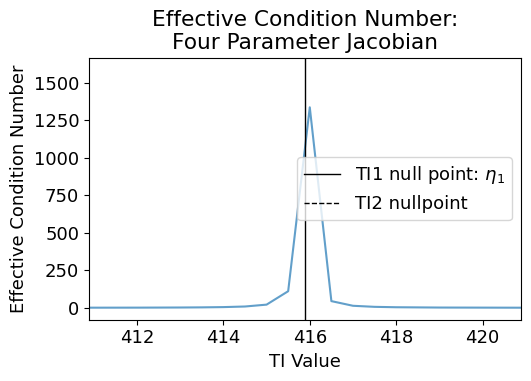

In [134]:
fig = plt.figure(1, figsize=(5.5,4), tight_layout=True)
plt.rc('font', size = 13)
plt.plot(TI_array, condition_4p_BTB*(1/SNR)**2, alpha = 0.7)
plt.axvline(x=TI1star, linewidth=1, label= r'TI1 null point: $\eta_1$', color='k')
if bothTI:
    plt.axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
plt.xlabel('TI Value')
plt.ylabel('Effective Condition Number')
plt.title('Effective Condition Number:' + '\nFour Parameter Jacobian')
plt.xlim((TI1star-5,TI1star+5))
plt.legend()
plt.show()

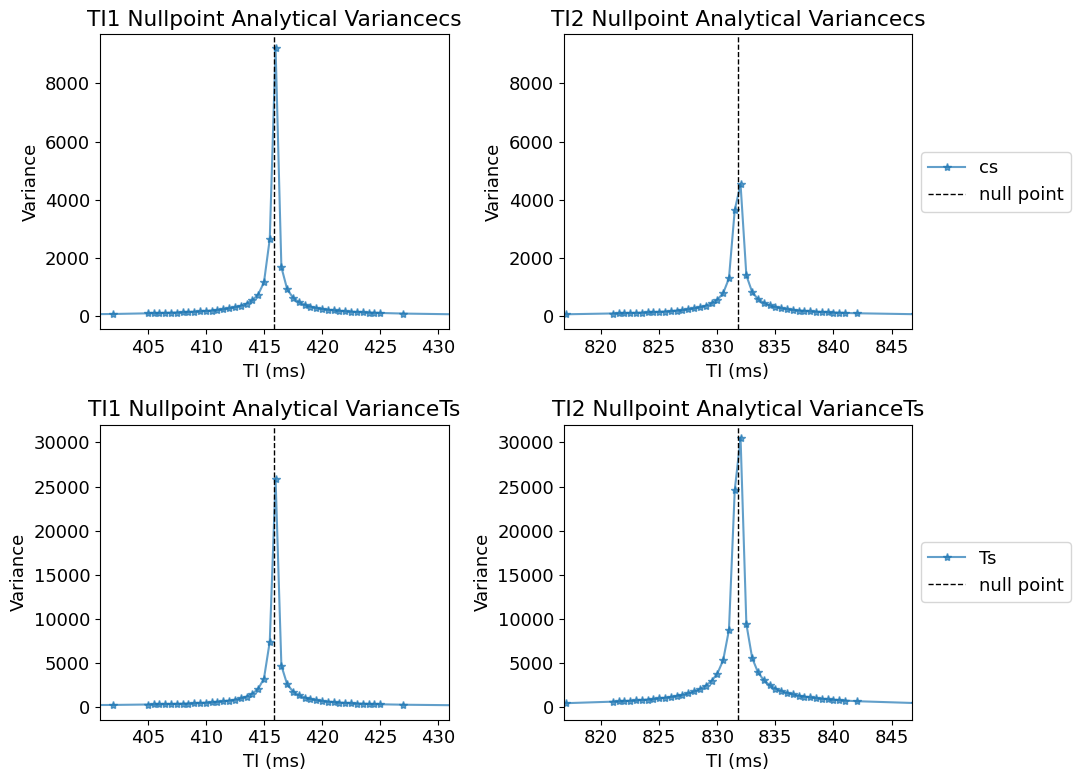

In [135]:
label_sequence =["cs", "Ts"]
plt.rc('font', size = 13)
fig, ax = plt.subplots(2,2, figsize=(11,8), tight_layout=True)
for i in range(2):
    ax[i,0].plot(TI_array, condition_6p_B_2x4subset[:,i], label = label_sequence[i], alpha = 0.7, marker = '*')
    ax[i,0].axvline(x=TI1star, linewidth=1, label= 'null point', color='k', ls = '--')
    ax[i,0].set_xlabel('TI (ms)')
    ax[i,0].set_ylabel('Variance')
    ax[i,0].set_title('TI1 Nullpoint Analytical Variance' + label_sequence[i])
    # ax[i,0].legend()
    ax[i,0].set_xlim([TI1star-rad, TI1star+rad])
    

    ax[i,1].plot(TI_array, condition_6p_B_2x4subset[:,i], label = label_sequence[i], alpha = 0.7, marker = '*')
    if bothTI:
        ax[i,1].axvline(x=TI2star, linewidth=1, label= 'null point', color='k', ls = '--')
    ax[i,1].set_xlabel('TI (ms)')
    ax[i,1].set_ylabel('Variance')
    ax[i,1].set_title('TI2 Nullpoint Analytical Variance' + label_sequence[i])
    ax[i,1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax[i,1].set_xlim([TI2star-rad, TI2star+rad])
plt.show()

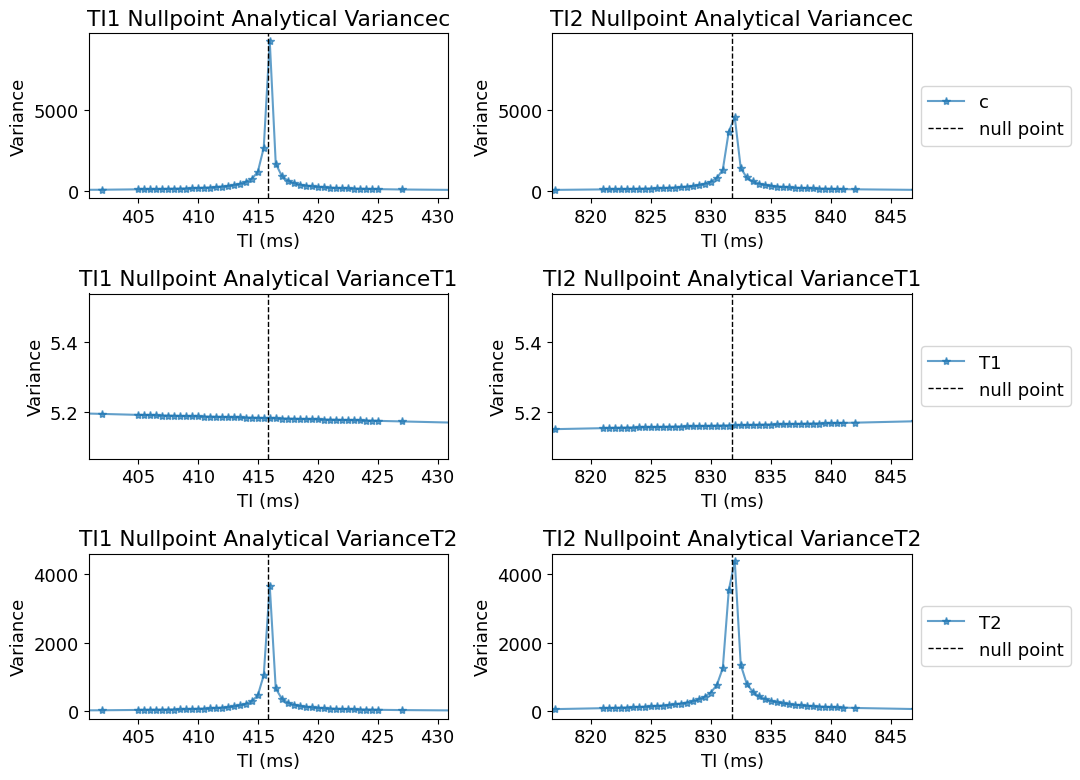

In [136]:
label_sequence =["c", "T1", "T2"]
plt.rc('font', size = 13)
fig, ax = plt.subplots(3,2, figsize=(11,8), tight_layout=True)
for i in range(3):
    ax[i,0].plot(TI_array, condition_6p_B_2subset[:,i], label = label_sequence[i], alpha = 0.7, marker = '*')
    ax[i,0].axvline(x=TI1star, linewidth=1, label= 'null point', color='k', ls = '--')
    ax[i,0].set_xlabel('TI (ms)')
    ax[i,0].set_ylabel('Variance')
    ax[i,0].set_title('TI1 Nullpoint Analytical Variance' + label_sequence[i])
    # ax[i,0].legend()
    ax[i,0].set_xlim([TI1star-rad, TI1star+rad])
    

    ax[i,1].plot(TI_array, condition_6p_B_2subset[:,i], label = label_sequence[i], alpha = 0.7, marker = '*')
    if bothTI:
        ax[i,1].axvline(x=TI2star, linewidth=1, label= 'null point', color='k', ls = '--')
    ax[i,1].set_xlabel('TI (ms)')
    ax[i,1].set_ylabel('Variance')
    ax[i,1].set_title('TI2 Nullpoint Analytical Variance' + label_sequence[i])
    ax[i,1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax[i,1].set_xlim([TI2star-rad, TI2star+rad])
plt.show()

##### Singular Value Plots

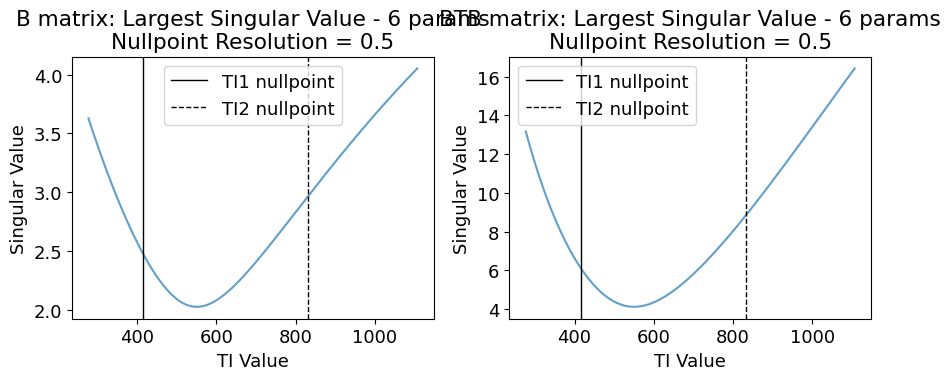

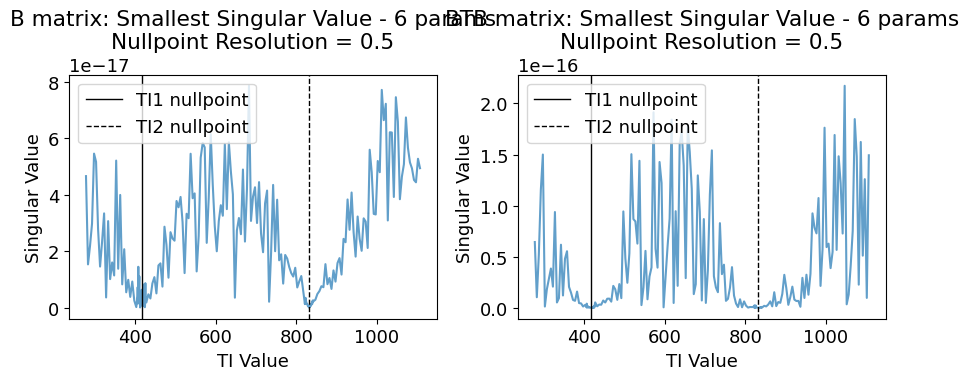

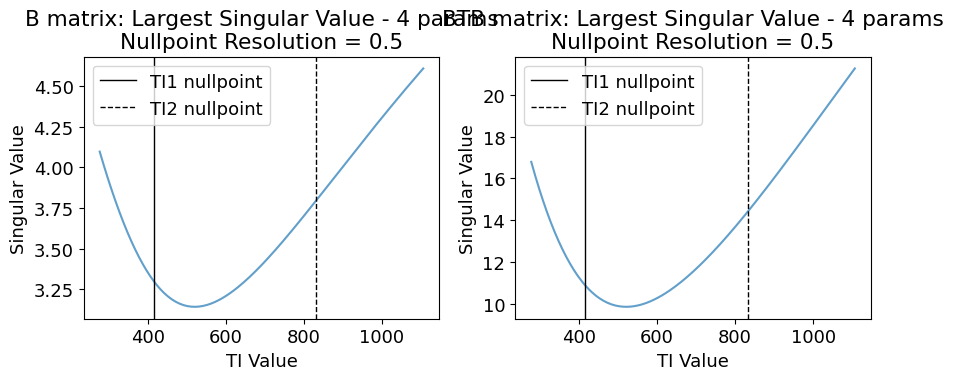

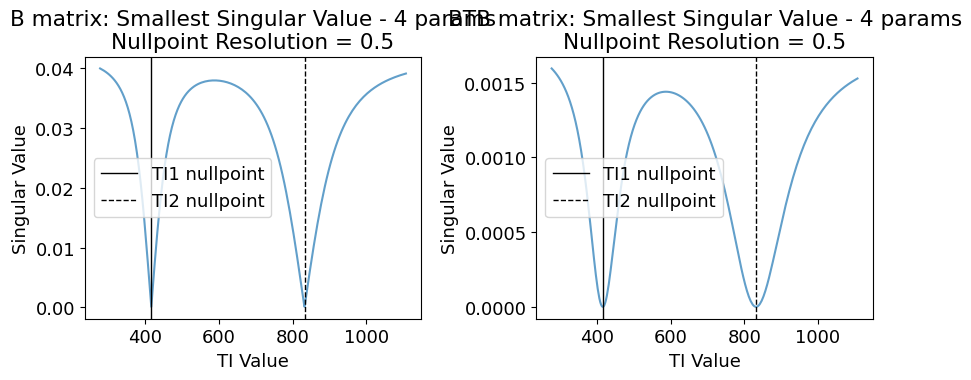

In [137]:
fig, ax = plt.subplots(1,2, figsize=(9,4), tight_layout=True)
ax[0].plot(TI_array, eigenBig_6p[:,0], alpha = 0.7)
ax[0].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
if bothTI:
    ax[0].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
ax[0].set_xlabel('TI Value')
ax[0].set_ylabel('Singular Value')
ax[0].set_title('B matrix: Largest Singular Value - 6 params'
            + '\nNullpoint Resolution = {:.1f}'.format(nullResolution) + CN_addendum)
ax[0].legend()

ax[1].plot(TI_array, eigenBig_6p[:,1], alpha = 0.7)
ax[1].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
if bothTI:
    ax[1].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
ax[1].set_xlabel('TI Value')
ax[1].set_ylabel('Singular Value')
ax[1].set_title('BTB matrix: Largest Singular Value - 6 params'
            + '\nNullpoint Resolution = {:.1f}'.format(nullResolution) + CN_addendum)
ax[1].legend()

fig, ax = plt.subplots(1,2, figsize=(9,4), tight_layout=True)
ax[0].plot(TI_array, eigenLil_6p[:,0], alpha = 0.7)
ax[0].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
if bothTI:
    ax[0].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
ax[0].set_xlabel('TI Value')
ax[0].set_ylabel('Singular Value')
ax[0].set_title('B matrix: Smallest Singular Value - 6 params'
            + '\nNullpoint Resolution = {:.1f}'.format(nullResolution) + CN_addendum)
ax[0].legend()

ax[1].plot(TI_array, eigenLil_6p[:,1], alpha = 0.7)
ax[1].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
if bothTI:
    ax[1].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
ax[1].set_xlabel('TI Value')
ax[1].set_ylabel('Singular Value')
ax[1].set_title('BTB matrix: Smallest Singular Value - 6 params'
            + '\nNullpoint Resolution = {:.1f}'.format(nullResolution) + CN_addendum)
ax[1].legend()

fig, ax = plt.subplots(1,2, figsize=(9,4), tight_layout=True)
ax[0].plot(TI_array, eigenBig_4p[:,0], alpha = 0.7)
ax[0].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
if bothTI:
    ax[0].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
ax[0].set_xlabel('TI Value')
ax[0].set_ylabel('Singular Value')
ax[0].set_title('B matrix: Largest Singular Value - 4 params'
            + '\nNullpoint Resolution = {:.1f}'.format(nullResolution))
ax[0].legend()

ax[1].plot(TI_array, eigenBig_4p[:,1], alpha = 0.7)
ax[1].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
if bothTI:
    ax[1].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
ax[1].set_xlabel('TI Value')
ax[1].set_ylabel('Singular Value')
ax[1].set_title('BTB matrix: Largest Singular Value - 4 params'
            + '\nNullpoint Resolution = {:.1f}'.format(nullResolution))
ax[1].legend()

fig, ax = plt.subplots(1,2, figsize=(9,4), tight_layout=True)
ax[0].plot(TI_array, eigenLil_4p[:,0], alpha = 0.7)
ax[0].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
if bothTI:
    ax[0].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
ax[0].set_xlabel('TI Value')
ax[0].set_ylabel('Singular Value')
ax[0].set_title('B matrix: Smallest Singular Value - 4 params'
            + '\nNullpoint Resolution = {:.1f}'.format(nullResolution))
ax[0].legend()

ax[1].plot(TI_array, eigenLil_4p[:,1], alpha = 0.7)
ax[1].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
if bothTI:
    ax[1].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
ax[1].set_xlabel('TI Value')
ax[1].set_ylabel('Singular Value')
ax[1].set_title('BTB matrix: Smallest Singular Value - 4 params'
            + '\nNullpoint Resolution = {:.1f}'.format(nullResolution))
ax[1].legend()

### Residual Sum of Squares

##### Residual Sum of Squares Plot - Noised

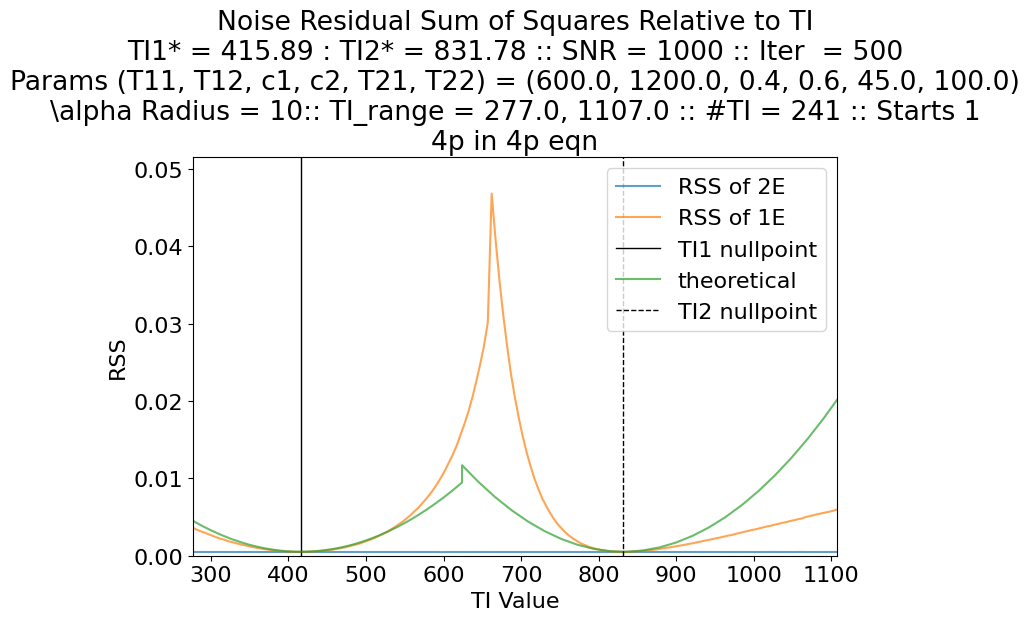

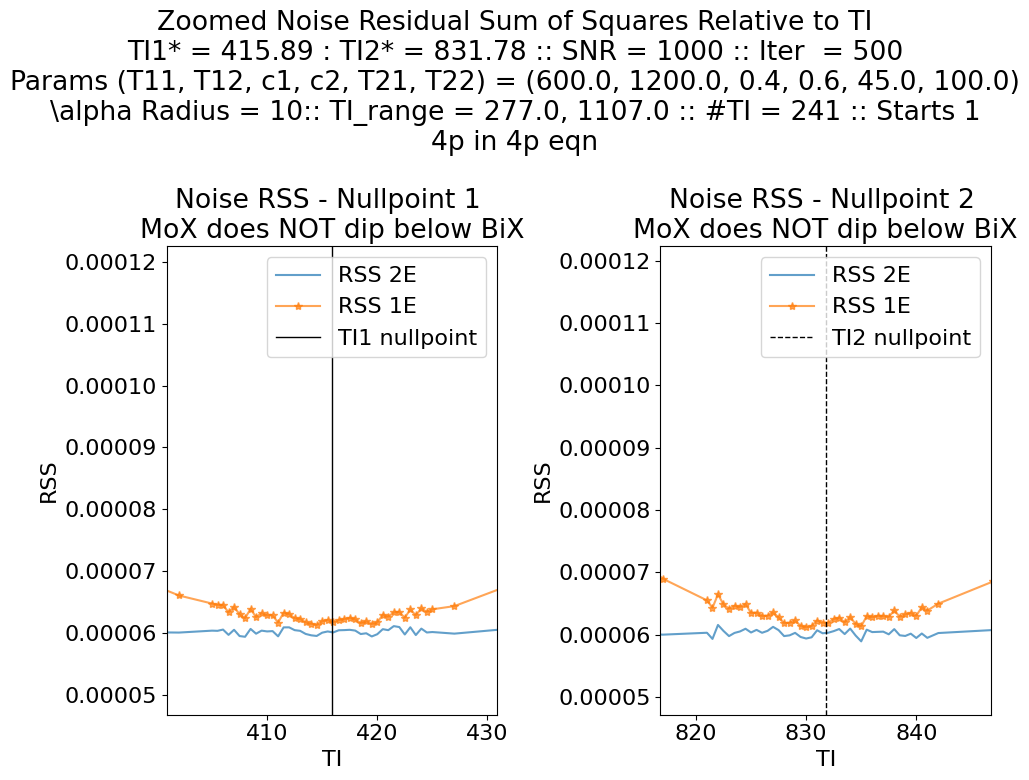

In [203]:
num_theoretical = 50
TI1_linspace = np.linspace(TI1star//10, np.mean([TI1star,TI2star]), num_theoretical)
TI2_linspace = np.linspace(np.mean([TI1star,TI2star]), TI2star*2, num_theoretical)

R0_coeff_TI1 = (c1**2 * T21 *(T21 - T22)**4)/(2*T11**2 * (T21 + T22)**4)
R0_coeff_TI2 = (c2**2 * T22 *(T21 - T22)**4)/(2*T12**2 * (T21 + T22)**4)
RSS_theoretical_1E_TI1subset = np.zeros(num_theoretical)
RSS_theoretical_1E_TI2subset = np.zeros(num_theoretical)
RSS_floor = np.size(TE_series)*(1/SNR)**2

for k in range(num_theoretical):

    TI1 = TI1_linspace[k]
    TI2 = TI2_linspace[k]

    RSS_theoretical_1E_TI1subset[k] = R0_coeff_TI1*(TI1 - TI1star)**2
    RSS_theoretical_1E_TI2subset[k] = R0_coeff_TI2*(TI2 - TI2star)**2

TE_diff = np.unique(np.diff(TE_series))
assert(TE_diff.shape[0] == 1)

TI_linspace = np.concatenate((TI1_linspace, TI2_linspace))
RSS_theoretical = np.concatenate((RSS_theoretical_1E_TI1subset, RSS_theoretical_1E_TI2subset))
RSS_theoretical = RSS_theoretical + np.size(TE_series)*(1/SNR)**2*TE_diff


nRSS_avg_2E = np.mean(RSS_Noise_Store_2E,axis = 1)
nRSS_avg_1E = np.mean(RSS_Noise_Store_1E,axis = 1)
fig = plt.figure(figsize=(8,6.5), tight_layout=True)
plt.plot(TI_array,nRSS_avg_2E * TE_diff, label = 'RSS of 2E', alpha = 0.7)
plt.plot(TI_array,nRSS_avg_1E * TE_diff, label = 'RSS of 1E', alpha = 0.7)
plt.axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
plt.plot(TI_linspace, RSS_theoretical, label = "theoretical", alpha = 0.7)
if bothTI:
    plt.axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
plt.xlabel('TI Value')
plt.ylabel('RSS')
plt.title('Noise Residual Sum of Squares Relative to TI' + details)
plt.legend()
plt.ylim([0,1.1*np.max(nRSS_avg_1E * TE_diff)])
plt.xlim([TI_array[0],TI_array[-1]])
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1,2,figsize=(10,8), tight_layout=True)
fig.suptitle('Zoomed Noise Residual Sum of Squares Relative to TI' + details)

minVal_1E = min(nRSS_avg_1E[0: np.size(nRSS_avg_1E)//2])
minVal_2E = min(nRSS_avg_2E[0: np.size(nRSS_avg_2E)//2])
min_meas = min([minVal_1E,minVal_2E])
max_meas = max([minVal_1E,minVal_2E])
ax[0].plot(TI_array, nRSS_avg_2E, label = 'RSS 2E', alpha = 0.7)
ax[0].plot(TI_array, nRSS_avg_1E, label = 'RSS 1E', alpha = 0.7, marker = '*')
if minVal_1E < minVal_2E:
    ax[0].set_title('Noise RSS - Nullpoint 1 \nMoX dips below BiX')
else:
    ax[0].set_title('Noise RSS - Nullpoint 1 \nMoX does NOT dip below BiX')
ax[0].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
ax[0].set_xlabel('TI')
ax[0].set_ylabel('RSS')
ax[0].set_ylim([0.8*min_meas,2*max_meas])
ax[0].set_xlim([TI1star-rad, TI1star+rad])
ax[0].legend()

minVal_1E = min(nRSS_avg_1E[np.size(nRSS_avg_1E)//2:])
minVal_2E = min(nRSS_avg_2E[np.size(nRSS_avg_2E)//2:])
min_meas = min([minVal_1E,minVal_2E])
max_meas = max([minVal_1E,minVal_2E])

ax[1].plot(TI_array, nRSS_avg_2E, label = 'RSS 2E', alpha = 0.7)
ax[1].plot(TI_array, nRSS_avg_1E, label = 'RSS 1E', alpha = 0.7, marker = '*')
if minVal_1E < minVal_2E:
    ax[1].set_title('Noise RSS - Nullpoint 2 \nMoX dips below BiX')
else:
    ax[1].set_title('Noise RSS - Nullpoint 2 \nMoX does NOT dip below BiX')
ax[1].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
ax[1].set_xlabel('TI')
ax[1].set_ylabel('RSS')
ax[1].set_ylim([0.8*min_meas,2*max_meas])
ax[1].set_xlim([TI2star-rad, TI2star+rad])
ax[1].legend()

##### Residual Sum of Squares - Region

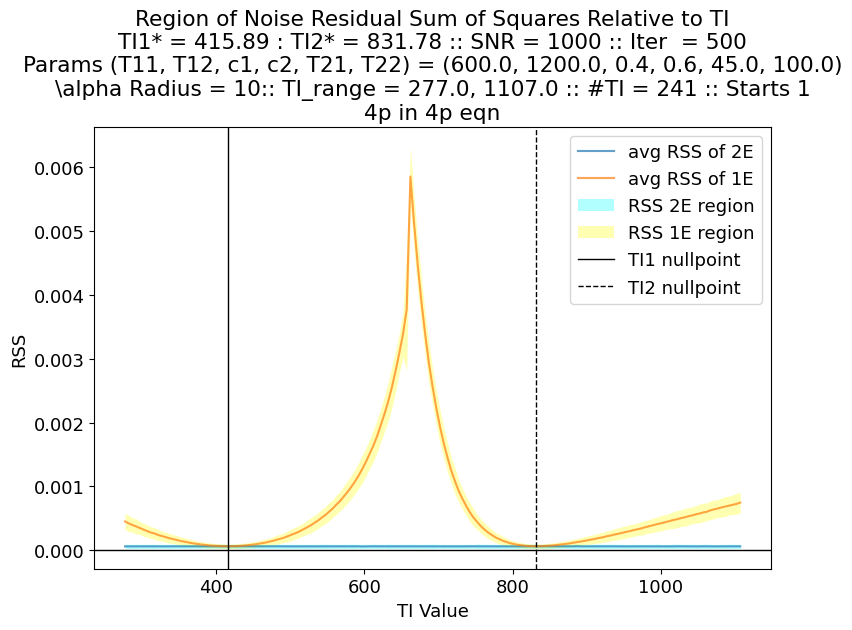

39 incorrect RSS pairings out of 120500 noisy signals
RSS violations at TI = 402.0 :: 1 violations
RSS violations at TI = 405.0 :: 1 violations
RSS violations at TI = 407.0 :: 2 violations
RSS violations at TI = 407.5 :: 1 violations
RSS violations at TI = 408.0 :: 1 violations
RSS violations at TI = 408.5 :: 1 violations
RSS violations at TI = 409.0 :: 3 violations
RSS violations at TI = 410.0 :: 2 violations
RSS violations at TI = 410.5 :: 3 violations
RSS violations at TI = 411.0 :: 1 violations
RSS violations at TI = 413.5 :: 2 violations
RSS violations at TI = 414.0 :: 1 violations
RSS violations at TI = 415.0 :: 1 violations
RSS violations at TI = 416.0 :: 1 violations
RSS violations at TI = 418.0 :: 1 violations
RSS violations at TI = 419.5 :: 2 violations
RSS violations at TI = 421.0 :: 1 violations
RSS violations at TI = 421.5 :: 2 violations
RSS violations at TI = 422.0 :: 1 violations
RSS violations at TI = 423.0 :: 2 violations
RSS violations at TI = 424.5 :: 1 violations
R

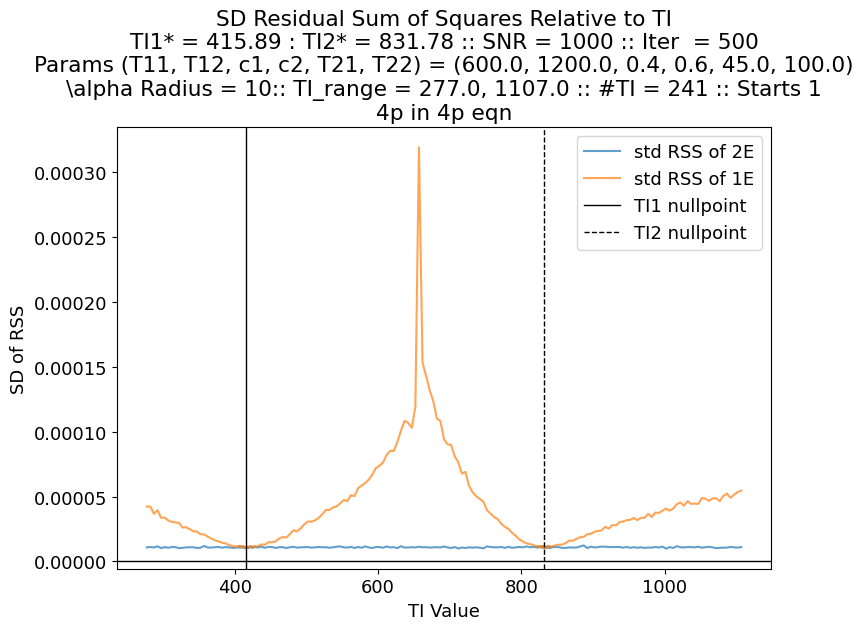

In [111]:
nRSS_sd_2E = np.std(RSS_Noise_Store_2E,axis = 1)
nRSS_sd_1E = np.std(RSS_Noise_Store_1E,axis = 1)

nRSS_ub_2E = nRSS_avg_2E + 3*nRSS_sd_2E
nRSS_lb_2E = nRSS_avg_2E - 3*nRSS_sd_2E
nRSS_ub_1E = nRSS_avg_1E + 3*nRSS_sd_1E
nRSS_lb_1E = nRSS_avg_1E - 3*nRSS_sd_1E

fig = plt.figure(figsize=(8,6.5), tight_layout=True)
plt.plot(TI_array,nRSS_avg_2E, label = 'avg RSS of 2E', alpha = 0.7)
plt.plot(TI_array,nRSS_avg_1E, label = 'avg RSS of 1E', alpha = 0.7)
plt.fill_between(TI_array,nRSS_lb_2E, nRSS_ub_2E, color = 'cyan', alpha = 0.3, lw=0, label = 'RSS 2E region')
plt.fill_between(TI_array,nRSS_lb_1E, nRSS_ub_1E, color = 'yellow', alpha = 0.3, lw=0, label = 'RSS 1E region')
plt.axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
plt.axhline(y=0, linewidth=1, color='k')
if bothTI:
    plt.axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
plt.xlabel('TI Value')
plt.ylabel('RSS')
plt.title('Region of Noise Residual Sum of Squares Relative to TI' + details)
plt.legend()
plt.tight_layout()
plt.show()

RSS_check = RSS_Noise_Store_2E > RSS_Noise_Store_1E
print(f"{np.sum(RSS_check)} incorrect RSS pairings out of {np.size(RSS_check)} noisy signals")
indices = np.nonzero(RSS_check)
indices_x = indices[0]
indices_y = indices[1]

TI_indices, TI_counts = np.unique(indices_x, return_counts = True)

for i in range(TI_indices.shape[0]):
    print(f"RSS violations at TI = {TI_array[TI_indices[i]]} :: {TI_counts[i]} violations")

fig = plt.figure(figsize=(8,6.5), tight_layout=True)
plt.plot(TI_array,nRSS_sd_2E, label = 'std RSS of 2E', alpha = 0.7)
plt.plot(TI_array,nRSS_sd_1E, label = 'std RSS of 1E', alpha = 0.7)
plt.axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
plt.axhline(y=0, linewidth=1, color='k')
if bothTI:
    plt.axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
plt.xlabel('TI Value')
plt.ylabel('SD of RSS')
plt.title('SD Residual Sum of Squares Relative to TI' + details)
plt.legend()
plt.tight_layout()
plt.show()

##### Residual Sum of Squares Theoretical

In [112]:
noiseless_ref = True   #Solve a bunch of soln with no noise added

TI1_subset_index = np.where([(x in TI1_array) for x in TI_array])

nRSS_avg_1E_TI1subset = nRSS_avg_1E[TI1_subset_index]
nRSS_avg_2E_TI1subset = nRSS_avg_2E[TI1_subset_index]

if noiseless_ref:
    RSS_noiseless_1E_TI1subset = np.zeros(TI1_array.shape)
    RSS_noiseless_2E_TI1subset = np.zeros(TI1_array.shape)


TE_diff = np.unique(np.diff(TE_series))
assert(TE_diff.shape[0] == 1)

RSS_ther_error = 0
R0_coeff_TI1 = (c1**2 * T21 *(T21 - T22)**4)/(2*T11**2 * (T21 + T22)**4)
RSS_theoretical_1E_TI1subset = np.zeros(TI1_array.shape)

starts_here = 15

for k in trange(np.size(TI1_array)):

    TI = TI1_array[k]

    RSS_theoretical_1E_TI1subset[k] = R0_coeff_TI1*(TI - TI1star)**2

    if noiseless_ref:
        true_d1 = d_value(TI, c1, T11)
        true_d2 = d_value(TI, c2, T12)

        realParams_4p = np.array([true_d1, true_d2, T21, T22])

        realParams = np.array([c1,c2,T21,T22])

        trueDat_4p = S_biX_4p(TE_series, *realParams_4p)
        trueDat = S_biX_6p(TE_series, TI, T11, T12, c1, c2, T21, T22)

        assert(np.allclose(trueDat,trueDat_4p))

        RSS_best = np.inf
        for start in range(starts_here):
            #Running all the biexponential fits
            try:
                ub = (1,1,T2_bound,T2_bound)
                lb = (-1,-1,0,0)

                init_p = np.array(lb) + (np.array(ub)- np.array(lb))*np.random.uniform(0,1,np.size(lb))
                init_p = list(init_p)

                popt_2E, pcov_2E = curve_fit(lambda t_dat,p1,p2,p3,p4 : S_biX_4p(t_dat,p1,p2,p3,p4), TE_series, trueDat_4p, p0 = init_p, bounds = [lb,ub], method = 'trf', maxfev = 1500)
                popt_2E = check_param_order(popt_2E)
                est_Sig_2E = S_biX_4p(TE_series, *popt_2E)

                RSS_hol = np.sum((est_Sig_2E - trueDat_4p)**2)

                if RSS_hol < RSS_best:
                    RSS_best = RSS_hol

            except Exception as e:
                print("Biexponential")
                print(e)
                continue

        RSS_noiseless_2E_TI1subset[k] = RSS_best

        try:
            init_p = ((true_d1 + true_d2)/2 , (T21 + T22)/2)

            popt_1E, pcov_1E = curve_fit(lambda t_dat,p1,p2 : S_moX_2p(t_dat,p1,p2), TE_series, trueDat_4p, p0 = init_p, maxfev = 1500)
            est_Sig_1E = S_moX_2p(TE_series,*popt_1E)
            RSS_noiseless_1E_TI1subset[k] = np.sum((est_Sig_1E - trueDat_4p)**2)

        except Exception as e:
            print(e)
            RSS_ther_error += 1
            continue


 44%|████▍     | 18/41 [00:16<00:21,  1.08it/s]


KeyboardInterrupt: 

In [ ]:
if bothTI:
    TI2_subset_index = np.where([(x in TI2_array) for x in TI_array])

    nRSS_avg_1E_TI2subset = nRSS_avg_1E[TI2_subset_index]
    nRSS_avg_2E_TI2subset = nRSS_avg_2E[TI2_subset_index]

    if noiseless_ref:
        RSS_noiseless_1E_TI2subset = np.zeros(TI2_array.shape)
        RSS_noiseless_2E_TI2subset = np.zeros(TI2_array.shape)

    RSS_ther_error = 0
    R0_coeff_TI2 = (c2**2 * T22 *(T21 - T22)**4)/(2*T12**2 * (T21 + T22)**4)
    RSS_theoretical_1E_TI2subset = np.zeros(TI2_array.shape)

    starts_here = 15

    for k in trange(np.size(TI2_array)):

        TI = TI2_array[k]

        RSS_theoretical_1E_TI2subset[k] = R0_coeff_TI2*(TI - TI2star)**2

        if noiseless_ref:
            true_d1 = d_value(TI, c1, T11)
            true_d2 = d_value(TI, c2, T12)

            realParams_4p = np.array([true_d1, true_d2, T21, T22])

            realParams = np.array([c1,c2,T21,T22])

            trueDat_4p = S_biX_4p(TE_series, *realParams_4p)
            trueDat = S_biX_6p(TE_series, TI, T11, T12, c1, c2, T21, T22)

            assert(np.allclose(trueDat,trueDat_4p))

            RSS_best = np.inf
            for start in range(starts_here):
                #Running all the biexponential fits
                try:
                    ub = (1,1,T2_bound,T2_bound)
                    lb = (-1,-1,0,0)

                    init_p = np.array(lb) + (np.array(ub)- np.array(lb))*np.random.uniform(0,1,np.size(lb))
                    init_p = list(init_p)

                    popt_2E, pcov_2E = curve_fit(lambda t_dat,p1,p2,p3,p4 : S_biX_4p(t_dat,p1,p2,p3,p4), TE_series, trueDat_4p, p0 = init_p, bounds = [lb,ub], method = 'trf', maxfev = 1500)
                    popt_2E = check_param_order(popt_2E)
                    est_Sig_2E = S_biX_4p(TE_series, *popt_2E)

                    RSS_hol = np.sum((est_Sig_2E - trueDat_4p)**2)

                    if RSS_hol < RSS_best:
                        RSS_best = RSS_hol

                except Exception as e:
                    print("Biexponential")
                    print(e)
                    continue

            RSS_noiseless_2E_TI2subset[k] = RSS_best

            try:
                init_p = ((true_d1 + true_d2)/2 , (T21 + T22)/2)

                popt_1E, pcov_1E = curve_fit(lambda t_dat,p1,p2 : S_moX_2p(t_dat,p1,p2), TE_series, trueDat_4p, p0 = init_p, maxfev = 1500)
                est_Sig_1E = S_moX_2p(TE_series,*popt_1E)
                RSS_noiseless_1E_TI2subset[k] = np.sum((est_Sig_1E - trueDat_4p)**2)

            except Exception as e:
                print(e)
                RSS_ther_error += 1
                continue


100%|██████████| 41/41 [00:15<00:00,  2.72it/s]


ValueError: x and y must have same first dimension, but have shapes (41,) and (50,)

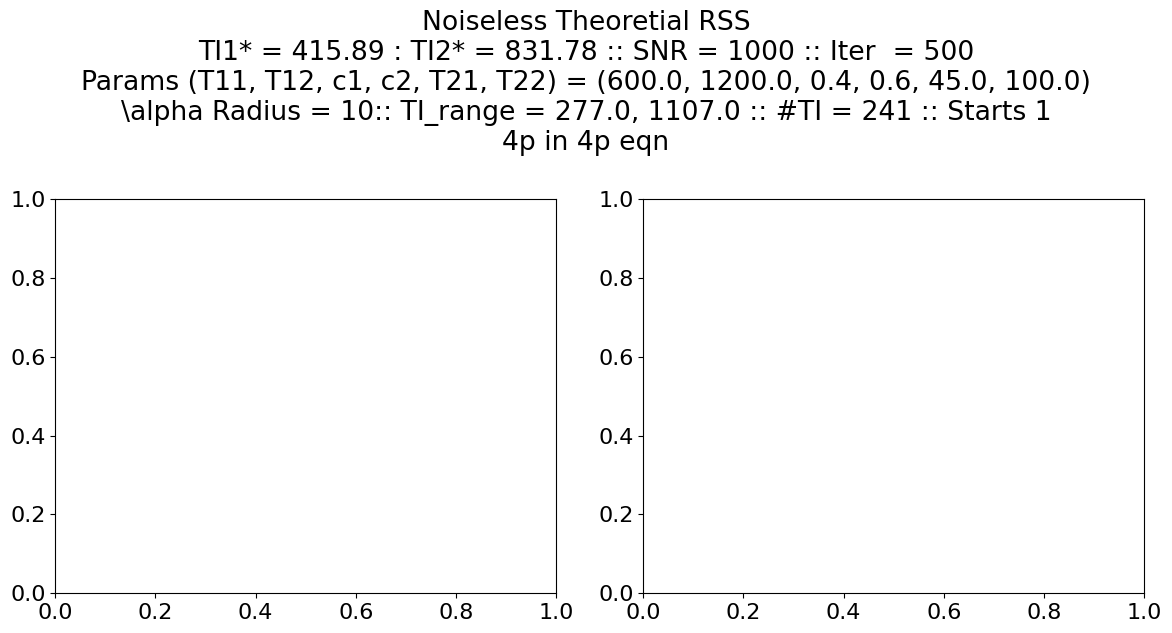

In [205]:
if noiseless_ref:
    if bothTI:
        fig, ax = plt.subplots(1,2, figsize=(12,6.5), tight_layout=True)
    else:
        fig, ax = plt.subplots(1,1, figsize=(10,6.5), tight_layout=True)
    fig.suptitle('Noiseless Theoretial RSS' + details)
    ax[0].plot(TI1_array, RSS_theoretical_1E_TI1subset, label = 'theoretical', alpha = 0.7)
    ax[0].plot(TI1_array, RSS_noiseless_2E_TI1subset*TE_diff, label = 'pure RSS of 2E', alpha = 0.7, marker = '*')
    ax[0].plot(TI1_array, RSS_noiseless_1E_TI1subset*TE_diff, label = 'pure RSS of 1E', alpha = 0.7, marker = '*')
    ax[0].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k', ls = '--')
    ax[0].set_xlabel('TI Value')
    ax[0].set_ylabel('RSS')
    ax[0].set_title('Theoretical RSS - TI1 nullpoint')
    # ax[0].legend()
    # ax[0].set_ylim([0,np.max(nRSS_avg_1E_TI1subset*TE_diff)])
    # ax[0].set_xlim([TI1star-2,TI1star+2])
    if bothTI:
        ax[1].plot(TI2_array, RSS_theoretical_1E_TI2subset, label = 'theoretical', alpha = 0.7)
        ax[1].plot(TI2_array, RSS_noiseless_2E_TI2subset*TE_diff, label = 'noiseless RSS of 2E', alpha = 0.7, marker = '*')
        ax[1].plot(TI2_array, RSS_noiseless_1E_TI2subset*TE_diff, label = 'noisless RSS of 1E', alpha = 0.7, marker = '*')
        ax[1].axvline(x=TI2star, linewidth=1, label= 'nullpoint', color='k', ls = '--')
        ax[1].set_xlabel('TI Value')
        ax[1].set_ylabel('RSS')
        ax[1].set_title('Theoretical RSS - TI2 nullpoint')
        ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
        # ax[1].set_ylim((0,np.max(RSS_theoretical_1E_TI2subset)))
    plt.show()

if bothTI:
    fig, ax = plt.subplots(1,2, figsize=(12,6.5), tight_layout=True)
else:
    fig, ax = plt.subplots(1,1, figsize=(10,6.5), tight_layout=True)
fig.suptitle('Theoretial RSS' + details)
ax[0].plot(TI1_array, RSS_theoretical_1E_TI1subset + np.size(TE_series)*(1/SNR)**2*TE_diff, label = 'theoretical', alpha = 0.7)
ax[0].plot(TI_array[TI1_subset_index], nRSS_avg_2E_TI1subset*TE_diff, label = 'noise RSS of 2E', alpha = 0.7, marker = '*')
ax[0].plot(TI_array[TI1_subset_index], nRSS_avg_1E_TI1subset*TE_diff, label = 'noise RSS of 1E', alpha = 0.7, marker = '*')
ax[0].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k', ls = '--')
ax[0].set_xlabel('TI Value')
ax[0].set_ylabel('RSS')
ax[0].set_title('Theoretical RSS - TI1 nullpoint')
# ax[0].legend()
# ax[0].set_ylim([0,np.max(nRSS_avg_1E_TI1subset*TE_diff)])
# ax[0].set_xlim([TI1star-5,TI1star+5])
if bothTI:
    ax[1].plot(TI2_array, RSS_theoretical_1E_TI2subset + (np.size(TE_series)-4)*(1/SNR)**2*TE_diff, label = 'theoretical', alpha = 0.7)
    ax[1].plot(TI_array[TI2_subset_index], nRSS_avg_2E_TI2subset*TE_diff, label = 'noise RSS of 2E', alpha = 0.7, marker = '*')
    ax[1].plot(TI_array[TI2_subset_index], nRSS_avg_1E_TI2subset*TE_diff, label = 'noise RSS of 1E', alpha = 0.7, marker = '*')
    ax[1].axvline(x=TI2star, linewidth=1, label= 'nullpoint', color='k', ls = '--')
    ax[1].set_xlabel('TI Value')
    ax[1].set_ylabel('RSS')
    ax[1].set_title('Theoretical RSS - TI2 nullpoint')
    ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # ax[1].set_ylim((0,np.max(RSS_theoretical_1E_TI2subset)))
plt.show()

In [ ]:
SNR_array = [750, 1000, 3000, 5000, 10000]
SNR_RSS_array_T1 = np.zeros((TI1_array.shape[0], np.size(SNR_array)))
SNR_RSS_array_T2 = np.zeros((TI2_array.shape[0], np.size(SNR_array)))

repetitions = 100

TE_diff = np.unique(np.diff(TE_series))
assert(TE_diff.shape[0] == 1)

R0_coeff_TI1 = (c1**2 * T21 *(T21 - T22)**4)/(2*T11**2 * (T21 + T22)**4)
RSS_theoretical_1E_TI1subset = np.zeros(TI1_array.shape)

R0_coeff_TI2 = (c2**2 * T22 *(T21 - T22)**4)/(2*T12**2 * (T21 + T22)**4)
RSS_theoretical_1E_TI2subset = np.zeros(TI2_array.shape)

for k in trange(np.size(TI1_array)):

    TI1 = TI1_array[k]
    RSS_theoretical_1E_TI1subset[k] = R0_coeff_TI1*(TI1 - TI1star)**2

    TI2 = TI2_array[k]
    RSS_theoretical_1E_TI2subset[k] = R0_coeff_TI2*(TI2 - TI2star)**2

    
    true_d1_T1 = d_value(TI1, c1, T11)
    true_d2_T1 = d_value(TI1, c2, T12)

    true_d1_T2 = d_value(TI2, c1, T11)
    true_d2_T2 = d_value(TI2, c2, T12)

    trueDat_T1 = S_biX_6p(TE_series, TI1, T11, T12, c1, c2, T21, T22)
    trueDat_T2 = S_biX_6p(TE_series, TI2, T11, T12, c1, c2, T21, T22)

    for iSNR in range(np.size(SNR_array)):
        
        repMat_T1 = []
        repMat_T2 = []
        for rep in range(repetitions):

            noiseDat_T1 = add_noise(trueDat_T1, SNR_array[iSNR])
            noiseDat_T2 = add_noise(trueDat_T2, SNR_array[iSNR])

            try:
                init_p = ((true_d1_T1 + true_d2_T1)/2 , (T21 + T22)/2)

                popt_1E_T1, _ = curve_fit(lambda t_dat,p1,p2 : S_moX_2p(t_dat,p1,p2), TE_series, noiseDat_T1, p0 = init_p, maxfev = 1500)
                est_Sig_1E_T1 = S_moX_2p(TE_series, *popt_1E_T1)

                repMat_T1.append( np.sum((est_Sig_1E_T1 - noiseDat_T1)**2))

                init_p = ((true_d1_T2 + true_d2_T2)/2 , (T21 + T22)/2)

                popt_1E_T2, _ = curve_fit(lambda t_dat,p1,p2 : S_moX_2p(t_dat,p1,p2), TE_series, noiseDat_T2, p0 = init_p, maxfev = 1500)
                est_Sig_1E_T2 = S_moX_2p(TE_series, *popt_1E_T2)

                repMat_T2.append(np.sum((est_Sig_1E_T2 - noiseDat_T2)**2))
                
        
            except Exception as e:
                print(e)
                RSS_ther_error += 1
                continue

        SNR_RSS_array_T1[k, iSNR] = np.mean(repMat_T1)
        SNR_RSS_array_T2[k, iSNR] = np.mean(repMat_T2)

100%|██████████| 41/41 [00:13<00:00,  3.14it/s]


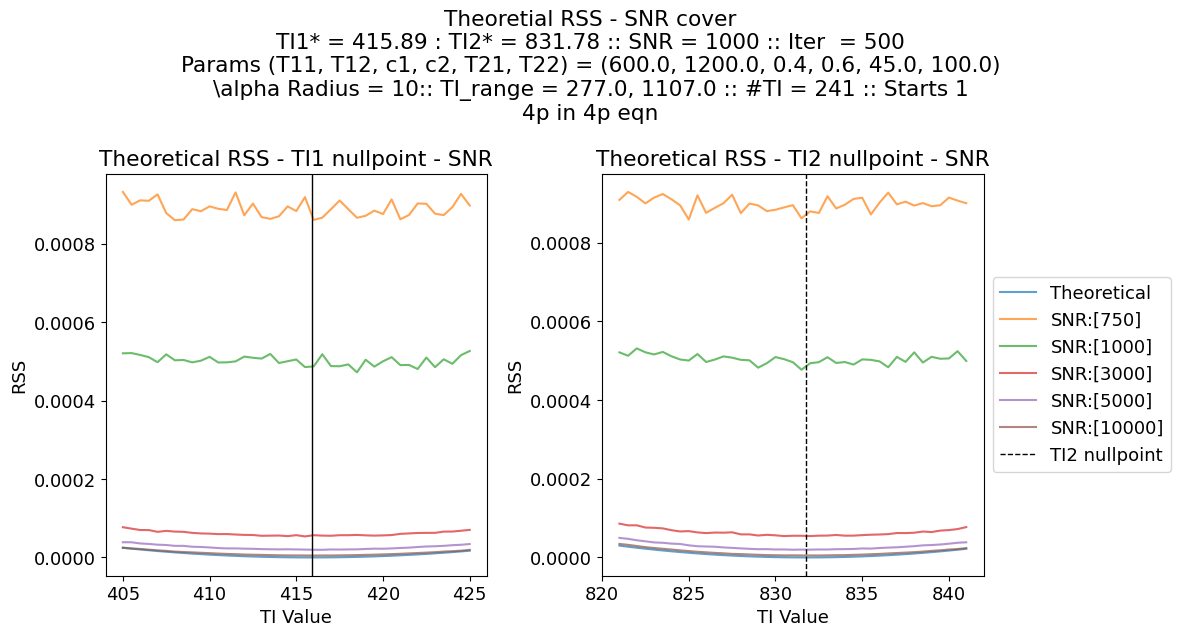

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12,6.5), tight_layout=True)
fig.suptitle('Theoretial RSS - SNR cover' + details)
ax[0].plot(TI1_array, RSS_theoretical_1E_TI1subset, label = 'Theoretical', alpha = 0.7)
for iPlot in range(np.size(SNR_array)):
    ax[0].plot(TI1_array, SNR_RSS_array_T1[:,iPlot]*TE_diff, label = f'SNR:[{SNR_array[iPlot]}]', alpha = 0.7)
ax[0].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
ax[0].set_xlabel('TI Value')
ax[0].set_ylabel('RSS')
ax[0].set_title('Theoretical RSS - TI1 nullpoint - SNR')
# ax[0].legend()


ax[1].plot(TI2_array, RSS_theoretical_1E_TI2subset, label = 'Theoretical', alpha = 0.7)
for iPlot in range(np.size(SNR_array)):
    ax[1].plot(TI2_array, SNR_RSS_array_T2[:,iPlot]*TE_diff, label = f'SNR:[{SNR_array[iPlot]}]', alpha = 0.7)
ax[1].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
ax[1].set_xlabel('TI Value')
ax[1].set_ylabel('RSS')
ax[1].set_title('Theoretical RSS - TI2 nullpoint - SNR')
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

##### Determine Offset Measure

In [78]:
SNR_array = np.array([750, 1000, 1500, 3000, 5000, 10000])
SNR_RSS_array_T1 = np.zeros((TI1_array.shape[0], np.size(SNR_array)))
SNR_RSS_array_T2 = np.zeros((TI2_array.shape[0], np.size(SNR_array)))

RSS_levels = np.size(TE_series)*(1/SNR_array)**2

RSS_levels_colors = _get_colors(np.size(SNR_array))

repetitions = 50

TE_diff = np.unique(np.diff(TE_series))
assert(TE_diff.shape[0] == 1)

R0_coeff_TI1 = (c1**2 * T21 *(T21 - T22)**4)/(2*T11**2 * (T21 + T22)**4)
RSS_theoretical_1E_TI1subset = np.zeros(TI1_array.shape)

R0_coeff_TI2 = (c2**2 * T22 *(T21 - T22)**4)/(2*T12**2 * (T21 + T22)**4)
RSS_theoretical_1E_TI2subset = np.zeros(TI2_array.shape)

for k in trange(np.size(TI1_array)):

    TI1 = TI1_array[k]
    RSS_theoretical_1E_TI1subset[k] = R0_coeff_TI1*(TI1 - TI1star)**2

    TI2 = TI2_array[k]
    RSS_theoretical_1E_TI2subset[k] = R0_coeff_TI2*(TI2 - TI2star)**2

    
    true_d1_T1 = d_value(TI1, c1, T11)
    true_d2_T1 = d_value(TI1, c2, T12)

    realParams_4p_T1 = np.array([true_d1_T1, true_d2_T2, T21, T22])

    true_d1_T2 = d_value(TI2, c1, T11)
    true_d2_T2 = d_value(TI2, c2, T12)

    realParams_4p_T2 = np.array([true_d1_T1, true_d2_T2, T21, T22])

    trueDat_T1 = S_biX_6p(TE_series, TI1, T11, T12, c1, c2, T21, T22)
    trueDat_T2 = S_biX_6p(TE_series, TI2, T11, T12, c1, c2, T21, T22)

    for iSNR in range(np.size(SNR_array)):
        
        repMat_T1 = []
        repMat_T2 = []
        for rep in range(repetitions):

            noiseDat_T1 = add_noise(trueDat_T1, SNR_array[iSNR])
            noiseDat_T2 = add_noise(trueDat_T2, SNR_array[iSNR])

            try:
                init_p = realParams_4p_T1
                    
                popt_2E_T1, _ = curve_fit(lambda t_dat,p1,p2,p3,p4 : S_biX_4p(t_dat,p1,p2,p3,p4), TE_series, noiseDat_T1, p0 = init_p, bounds = [lb,ub], method = 'trf', maxfev = 1500)
                popt_2E_T1 = check_param_order(popt_2E_T1)
                est_Sig_2E_T1 = S_biX_4p(TE_series, *popt_2E_T1)

                repMat_T1.append( np.sum((est_Sig_2E_T1 - noiseDat_T1)**2))

                init_p = realParams_4p_T2

                popt_2E_T2, _ = curve_fit(lambda t_dat,p1,p2,p3,p4 : S_biX_4p(t_dat,p1,p2,p3,p4), TE_series, noiseDat_T2, p0 = init_p, bounds = [lb,ub], method = 'trf', maxfev = 1500)
                popt_2E_T2 = check_param_order(popt_2E_T2)
                est_Sig_2E_T2 = S_biX_4p(TE_series, *popt_2E_T2)

                repMat_T2.append( np.sum((est_Sig_2E_T2 - noiseDat_T2)**2))
                
        
            except Exception as e:
                print(e)
                RSS_ther_error += 1
                continue

        SNR_RSS_array_T1[k, iSNR] = np.mean(repMat_T1)
        SNR_RSS_array_T2[k, iSNR] = np.mean(repMat_T2)

100%|██████████| 41/41 [10:43<00:00, 15.70s/it]


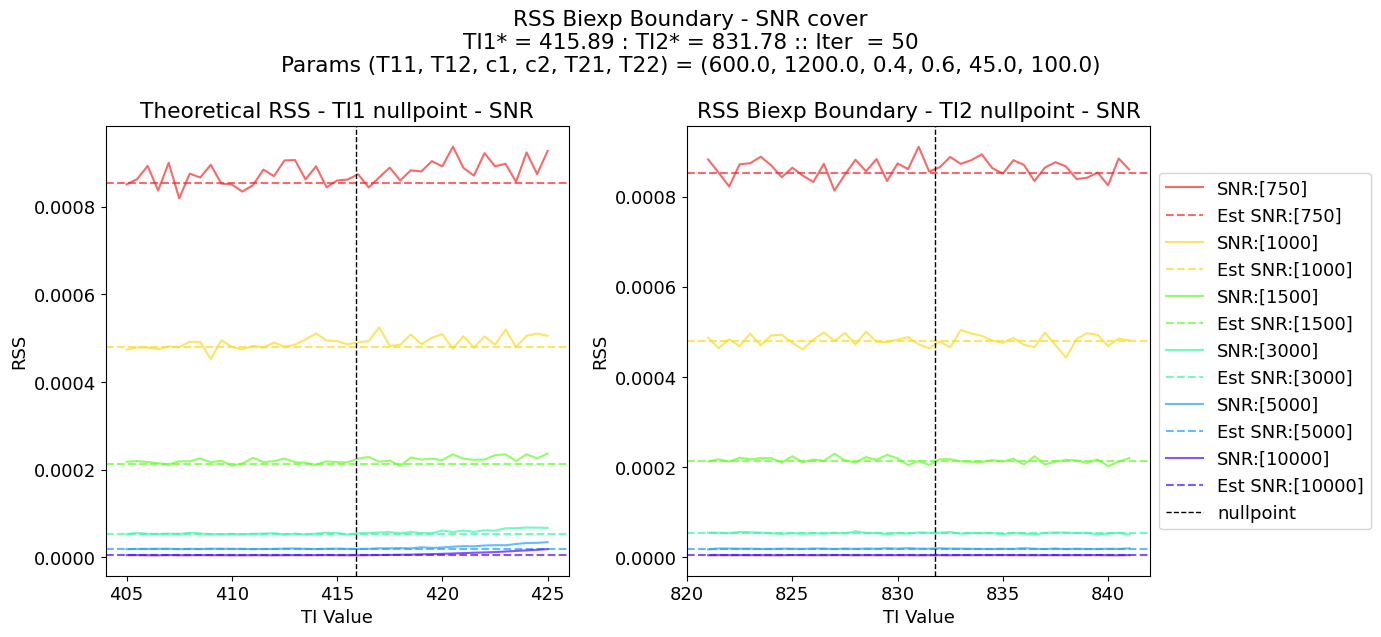

In [79]:
RSS_levels_colors = _get_colors(7)
RSS_levels = (np.size(TE_series)-4)*(1/SNR_array)**2
details_RSS = str('\nTI1* = ' + str(round(TI1star,2)) + ' : TI2* = ' + str(round(TI2star,2)) + " :: Iter  = " + str(repetitions) +
            '\nParams (' + pTitleList + ') = ' + '('+ pList + ')')

fig, ax = plt.subplots(1,2, figsize=(14,6.5), tight_layout=True)
fig.suptitle('RSS Biexp Boundary - SNR cover' + details_RSS)
for iPlot in range(np.size(SNR_array)):
    ax[0].plot(TI1_array, SNR_RSS_array_T1[:,iPlot]*TE_diff, label = f'SNR:[{SNR_array[iPlot]}]', alpha = 0.7, color = RSS_levels_colors[iPlot])
    ax[0].axhline(y = RSS_levels[iPlot]*TE_diff, label = f'Est SNR:[{SNR_array[iPlot]}]', alpha = 0.7, color = RSS_levels_colors[iPlot], ls = '--')
ax[0].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k', ls = '--')
ax[0].set_xlabel('TI Value')
ax[0].set_ylabel('RSS')
ax[0].set_title('Theoretical RSS - TI1 nullpoint - SNR')
# ax[0].legend()

for iPlot in range(np.size(SNR_array)):
    ax[1].plot(TI2_array, SNR_RSS_array_T2[:,iPlot]*TE_diff, label = f'SNR:[{SNR_array[iPlot]}]', alpha = 0.7, color = RSS_levels_colors[iPlot])
    ax[1].axhline(y = RSS_levels[iPlot]*TE_diff, label = f'Est SNR:[{SNR_array[iPlot]}]', alpha = 0.7, color = RSS_levels_colors[iPlot], ls = '--')
ax[1].axvline(x=TI2star, linewidth=1, label= 'nullpoint', color='k', ls = '--')
ax[1].set_xlabel('TI Value')
ax[1].set_ylabel('RSS')
ax[1].set_title('RSS Biexp Boundary - TI2 nullpoint - SNR')
box = ax[1].get_position()
# Put a legend to the right of the current axis
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

##### Parameter Theoretical Curves

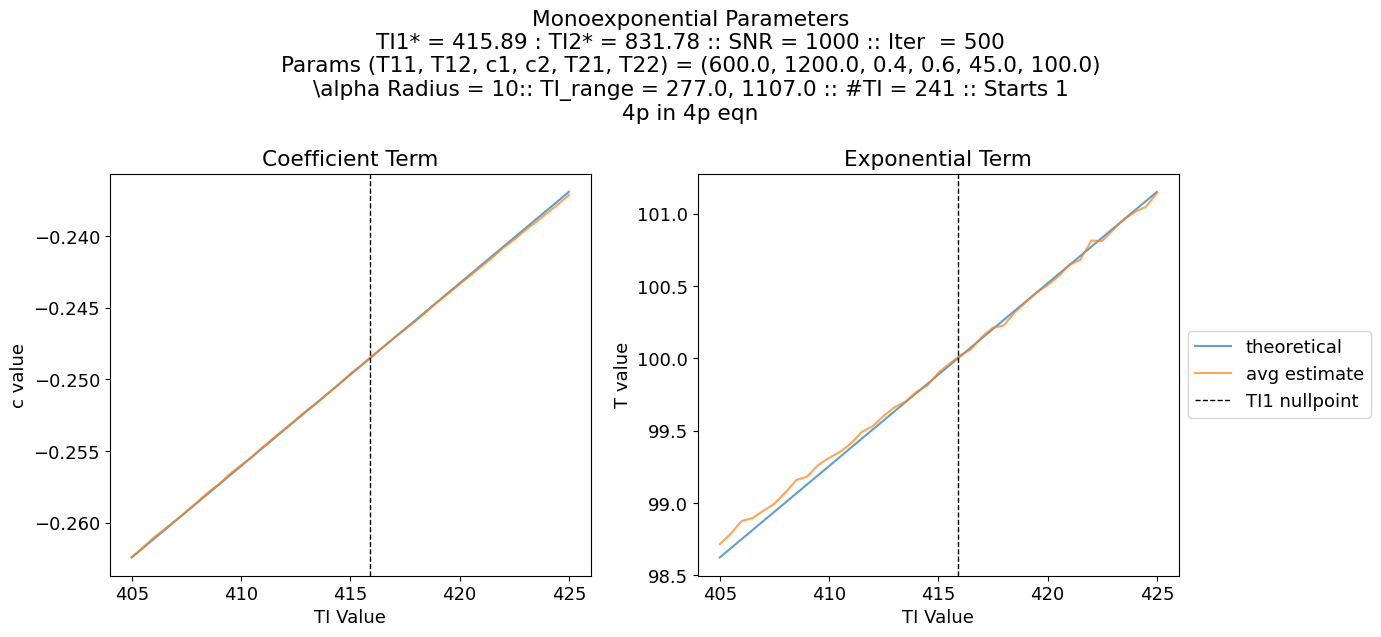

In [80]:
fstar = c2 * (1 - 2**(1 - T11/T12))
Tstar = T22

TI1_subset_index = np.where([(x in TI1_array) for x in TI_array])

avg_1E_params = np.mean(paramStore_1E, axis = 1)
avg_1E_c = avg_1E_params[:,0]
avg_1E_T = avg_1E_params[:,1]
avg_1E_c = avg_1E_c[TI1_subset_index]
avg_1E_T = avg_1E_T[TI1_subset_index]


f_array = fstar + (4*c1*T21*T22/(T11*(T21+T22)**2) + c2*2**(1 - T11/T12)/T12) * (TI1_array - TI1star)
# print((4*c1*T21*T22/(T11*(T21+T22)**2) + fstar/T12))
T_array = Tstar + (4*c1*T21*T22*(T21-T22)/(fstar*T11*(T21+T22)**2)) * (TI1_array - TI1star)

fig, ax = plt.subplots(1,2, figsize=(14,6.5), tight_layout=True)
fig.suptitle('Monoexponential Parameters' + details)
ax[0].plot(TI1_array, f_array, label = 'theoretical', alpha = 0.7)
ax[0].plot(TI1_array, avg_1E_c, label = 'avg estimate', alpha = 0.7)
ax[0].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k', ls = '--')
ax[0].set_xlabel('TI Value')
ax[0].set_ylabel('c value')
ax[0].set_title('Coefficient Term')
# ax[0].set_xlim([412,418])
# ax[0].set_ylim([-.208,-.20])
# ax[0].legend()

ax[1].plot(TI1_array, T_array, label = 'theoretical', alpha = 0.7)
ax[1].plot(TI1_array, avg_1E_T, label = 'avg estimate', alpha = 0.7)
ax[1].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k', ls = '--')
ax[1].set_xlabel('TI Value')
ax[1].set_ylabel('T value')
ax[1].set_title('Exponential Term')
# Put a legend to the right of the current axis
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Information Criteria - AIC, BIC, R2, Cp

Biexponential Information at TI1 nullpoint :: RSS = 6.01e-05 :: AIC d term = 8.00e-06 :: BIC d term = 1.66e-05
Monoexponential Information at TI1 nullpoint :: RSS = 6.17e-05 :: AIC d term = 4.00e-06 :: BIC d term = 8.32e-06
Difference at TI1 nullpoint :: RSS = -1.65e-06 :: AIC d term = -4.00e-06 :: BIC d term = -8.32e-06


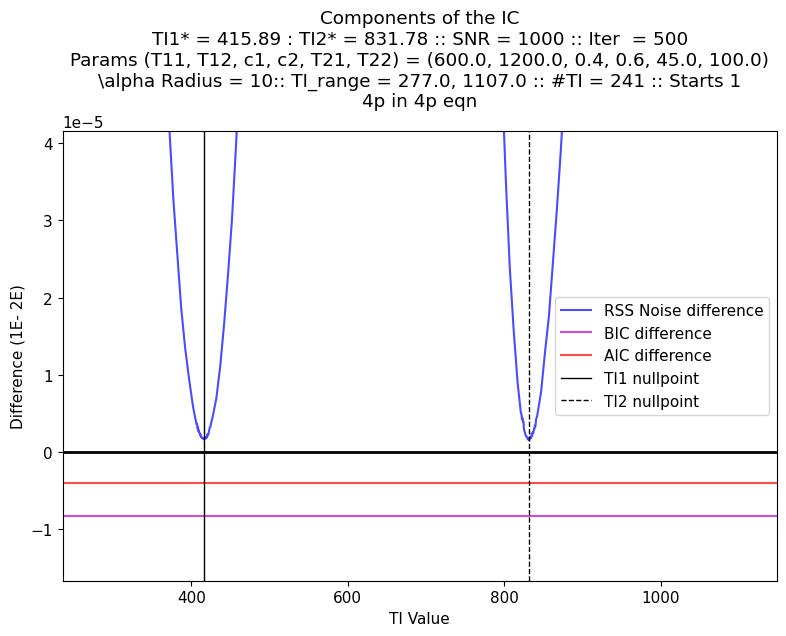

In [230]:
RSS_avg_2E = np.mean(RSS_Noise_Store_2E,axis = 1)
RSS_avg_1E = np.mean(RSS_Noise_Store_1E,axis = 1)
label_RSS = "RSS Noise difference"

TI1_index = np.argmin((TI_array-TI1star)**2)

RSS_2E = RSS_avg_2E[TI1_index] 
RSS_1E = RSS_avg_1E[TI1_index] 
RSS_diff = RSS_2E - RSS_1E

AIC_2E_d = 2 * np.size(estParams)*noiseSigma**2
BIC_2E_d = np.log(TE_series.shape[0]) * np.size(estParams)*noiseSigma**2

AIC_1E_d = 2 * np.size(MonoTitle)*noiseSigma**2
BIC_1E_d = np.log(TE_series.shape[0]) * np.size(MonoTitle)*noiseSigma**2

BIC_diff_d = BIC_1E_d - BIC_2E_d
AIC_diff_d = AIC_1E_d - AIC_2E_d

print("Biexponential Information at TI1 nullpoint :: RSS = " + "{:.2e}".format(RSS_2E) + " :: AIC d term = " + "{:.2e}".format(AIC_2E_d) + " :: BIC d term = " + "{:.2e}".format(BIC_2E_d))
print("Monoexponential Information at TI1 nullpoint :: RSS = " + "{:.2e}".format(RSS_1E) + " :: AIC d term = " + "{:.2e}".format(AIC_1E_d) + " :: BIC d term = " + "{:.2e}".format(BIC_1E_d))
print("Difference at TI1 nullpoint :: RSS = " + "{:.2e}".format(RSS_diff) + " :: AIC d term = " + "{:.2e}".format(AIC_diff_d) + " :: BIC d term = " + "{:.2e}".format(BIC_diff_d))


fig = plt.figure(figsize=(8,6.5), tight_layout=True)
plt.plot(TI_array, RSS_avg_1E - RSS_avg_2E, label = label_RSS, alpha = 0.7, color = 'b')
plt.axhline(y = BIC_diff_d, label = 'BIC difference', alpha = 0.7, color = 'm')
plt.axhline(y = AIC_diff_d, label = 'AIC difference', alpha = 0.7, color = 'r')
plt.axhline(y = 0, alpha = 1, color = 'k', linewidth=2)
plt.axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
if bothTI:
    plt.axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
plt.xlabel('TI Value')
plt.ylabel('Difference (1E- 2E)')
plt.title('Components of the IC' + details)
plt.ylim([2*BIC_diff_d,-5*BIC_diff_d])
plt.legend()
plt.tight_layout()
plt.show()

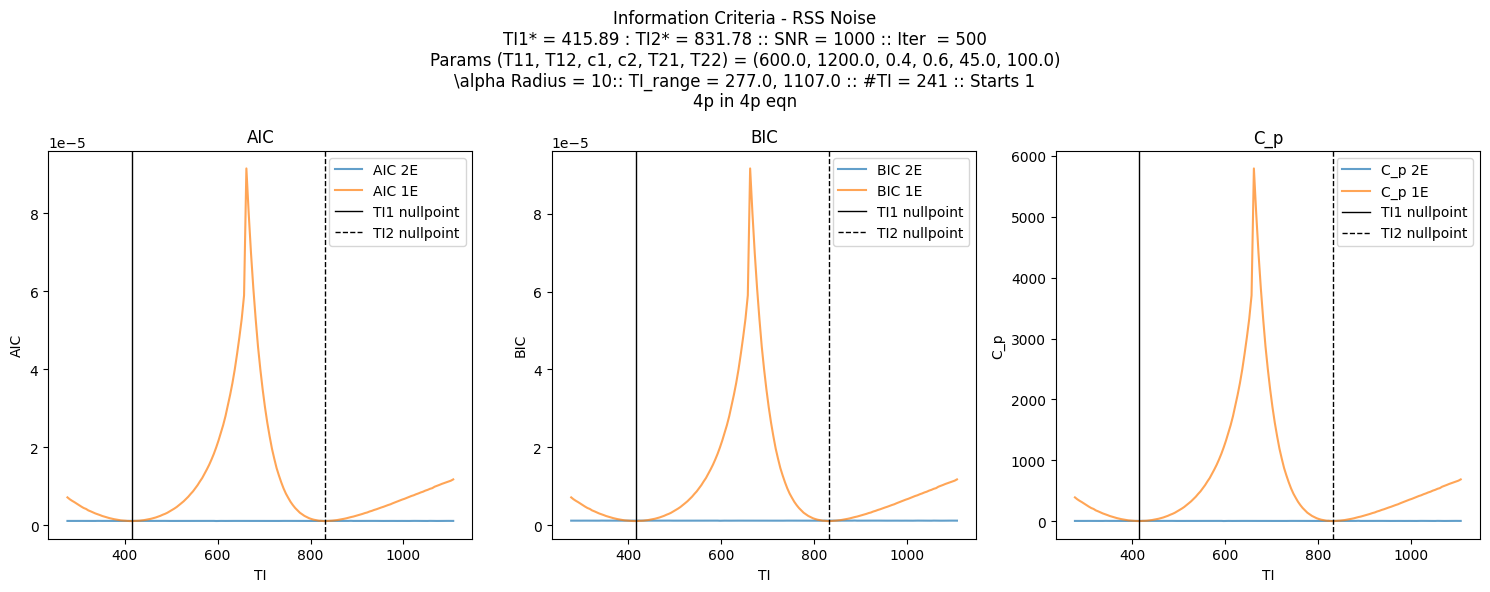

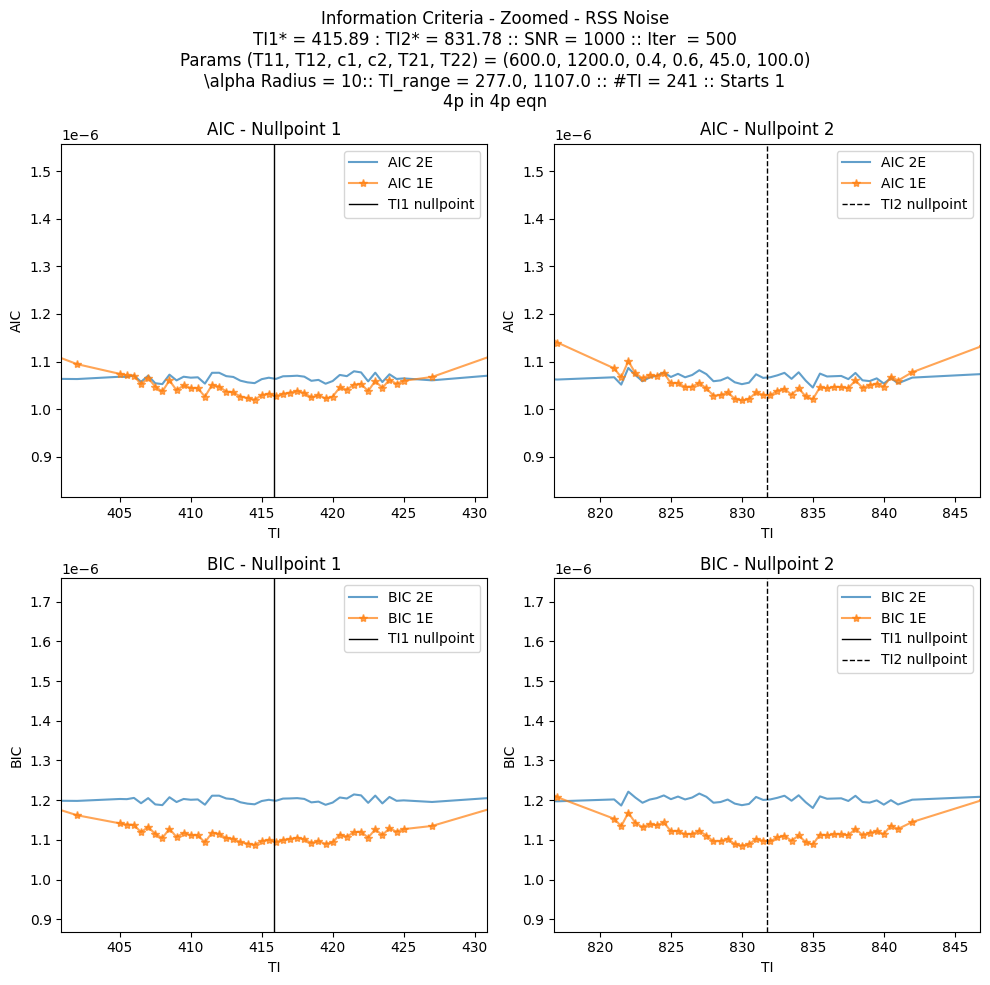

In [231]:
plt.rc('font', size = 10)

RSS_avg_2E = np.mean(RSS_Noise_Store_2E,axis = 1)
RSS_avg_1E = np.mean(RSS_Noise_Store_1E,axis = 1)
label_RSS = "RSS Noise"

AIC_2E = 1/TE_series.shape[0] * (RSS_avg_2E + 2 * np.size(estParams)*noiseSigma**2)
AIC_1E = 1/TE_series.shape[0] * (RSS_avg_1E + 2 * np.size(MonoTitle)*noiseSigma**2)

BIC_2E = 1/TE_series.shape[0] * (RSS_avg_2E + np.log(TE_series.shape[0]) * np.size(estParams)*noiseSigma**2)
BIC_1E = 1/TE_series.shape[0] * (RSS_avg_1E + np.log(TE_series.shape[0]) * np.size(MonoTitle)*noiseSigma**2)

Cp_2E = RSS_avg_2E/noiseSigma**2 + 2*np.size(estParams) - TE_series.shape[0]
Cp_1E = RSS_avg_1E/noiseSigma**2 + 2*np.size(MonoTitle) - TE_series.shape[0]

fig, ax = plt.subplots(1,3,figsize=(15,6), tight_layout=True)
fig.suptitle('Information Criteria - ' + label_RSS + details)


ax[0].plot(TI_array, AIC_2E, label = 'AIC 2E', alpha = 0.7)
ax[0].plot(TI_array, AIC_1E, label = 'AIC 1E', alpha = 0.7)
ax[0].set_title('AIC')
ax[0].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
if bothTI:
    ax[0].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
ax[0].set_xlabel('TI')
ax[0].set_ylabel('AIC')
ax[0].legend()

ax[1].plot(TI_array, BIC_2E, label = 'BIC 2E', alpha = 0.7)
ax[1].plot(TI_array, BIC_1E, label = 'BIC 1E', alpha = 0.7)
ax[1].set_title('BIC')
ax[1].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
if bothTI:
    ax[1].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
ax[1].set_xlabel('TI')
ax[1].set_ylabel('BIC')
ax[1].legend()

ax[2].plot(TI_array, Cp_2E, label = 'C_p 2E', alpha = 0.7)
ax[2].plot(TI_array, Cp_1E, label = 'C_p 1E', alpha = 0.7)
ax[2].set_title('C_p')
ax[2].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
ax[2].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
ax[2].set_xlabel('TI')
ax[2].set_ylabel('C_p')
ax[2].legend()

fig, ax = plt.subplots(2,2,figsize=(10,10), tight_layout=True)
fig.suptitle('Information Criteria - Zoomed - ' + label_RSS + details)

minVal_1E = min(AIC_1E)
minVal_2E = min(AIC_2E)
ax[0,0].plot(TI_array, AIC_2E, label = 'AIC 2E', alpha = 0.7)
ax[0,0].plot(TI_array, AIC_1E, label = 'AIC 1E', alpha = 0.7, marker = "*")
ax[0,0].set_title('AIC - Nullpoint 1')
ax[0,0].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
ax[0,0].set_xlabel('TI')
ax[0,0].set_ylabel('AIC')
ax[0,0].set_ylim([0.8*minVal_1E,1.5*minVal_2E])
ax[0,0].set_xlim([TI1star-rad, TI1star+rad])
ax[0,0].legend()

ax[0,1].plot(TI_array, AIC_2E, label = 'AIC 2E', alpha = 0.7)
ax[0,1].plot(TI_array, AIC_1E, label = 'AIC 1E', alpha = 0.7, marker = "*")
ax[0,1].set_title('AIC - Nullpoint 2')
ax[0,1].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
ax[0,1].set_xlabel('TI')
ax[0,1].set_ylabel('AIC')
ax[0,1].set_ylim([0.8*minVal_1E,1.5*minVal_2E])
ax[0,1].set_xlim([TI2star-rad, TI2star+rad])
ax[0,1].legend()

minVal_1E = min(BIC_1E)
minVal_2E = min(BIC_2E)
ax[1,0].plot(TI_array, BIC_2E, label = 'BIC 2E', alpha = 0.7)
ax[1,0].plot(TI_array, BIC_1E, label = 'BIC 1E', alpha = 0.7, marker = "*")
ax[1,0].set_title('BIC - Nullpoint 1')
ax[1,0].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
ax[1,0].set_xlabel('TI')
ax[1,0].set_ylabel('BIC')
ax[1,0].set_ylim([0.8*minVal_1E,1.5*minVal_2E])
ax[1,0].set_xlim([TI1star-rad, TI1star+rad])
ax[1,0].legend()

ax[1,1].plot(TI_array, BIC_2E, label = 'BIC 2E', alpha = 0.7)
ax[1,1].plot(TI_array, BIC_1E, label = 'BIC 1E', alpha = 0.7, marker = "*")
ax[1,1].set_title('BIC - Nullpoint 2')
ax[1,1].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
ax[1,1].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
ax[1,1].set_xlabel('TI')
ax[1,1].set_ylabel('BIC')
ax[1,1].set_ylim([0.8*minVal_1E,1.5*minVal_2E])
ax[1,1].set_xlim([TI2star-rad, TI2star+rad])
ax[1,1].legend()


##### Official Figure - BIC

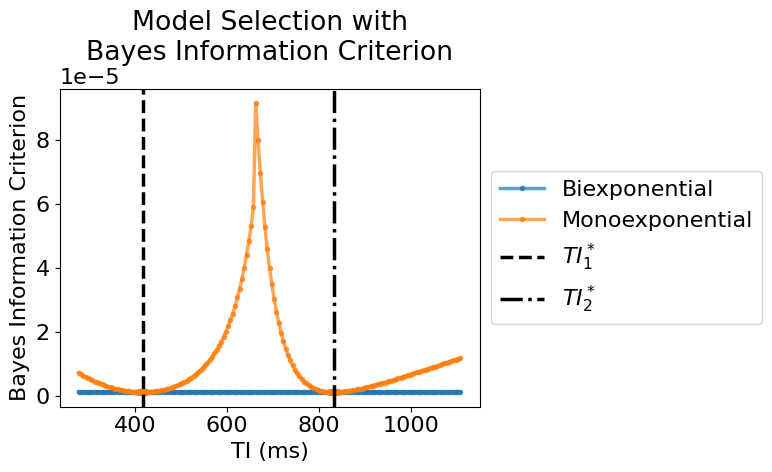

In [232]:
##################### Official Figure
fig= plt.figure(figsize=(8,5), tight_layout=True)
plt.rc('font', size = 16)

plt.plot(TI_array, BIC_2E, label = 'Biexponential', alpha = 0.7, marker = 'o', lw = 2.5, ms = 3)
plt.plot(TI_array, BIC_1E, label = 'Monoexponential', alpha = 0.7, marker = 'o', lw = 2.5, ms = 3)
plt.title('Bayes Information Criterion')
plt.axvline(x=TI1star, label= r'$TI^*_1$', color='k', ls = '--', lw = 2.5)
plt.axvline(x=TI2star, label= r'$TI^*_2$', color='k', ls = '-.', lw = 2.5)
plt.xlabel('TI (ms)')
plt.ylabel('Bayes Information Criterion')
plt.title('Model Selection with\nBayes Information Criterion')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

Text(0.5, 1.0, 'Full TI Domain')

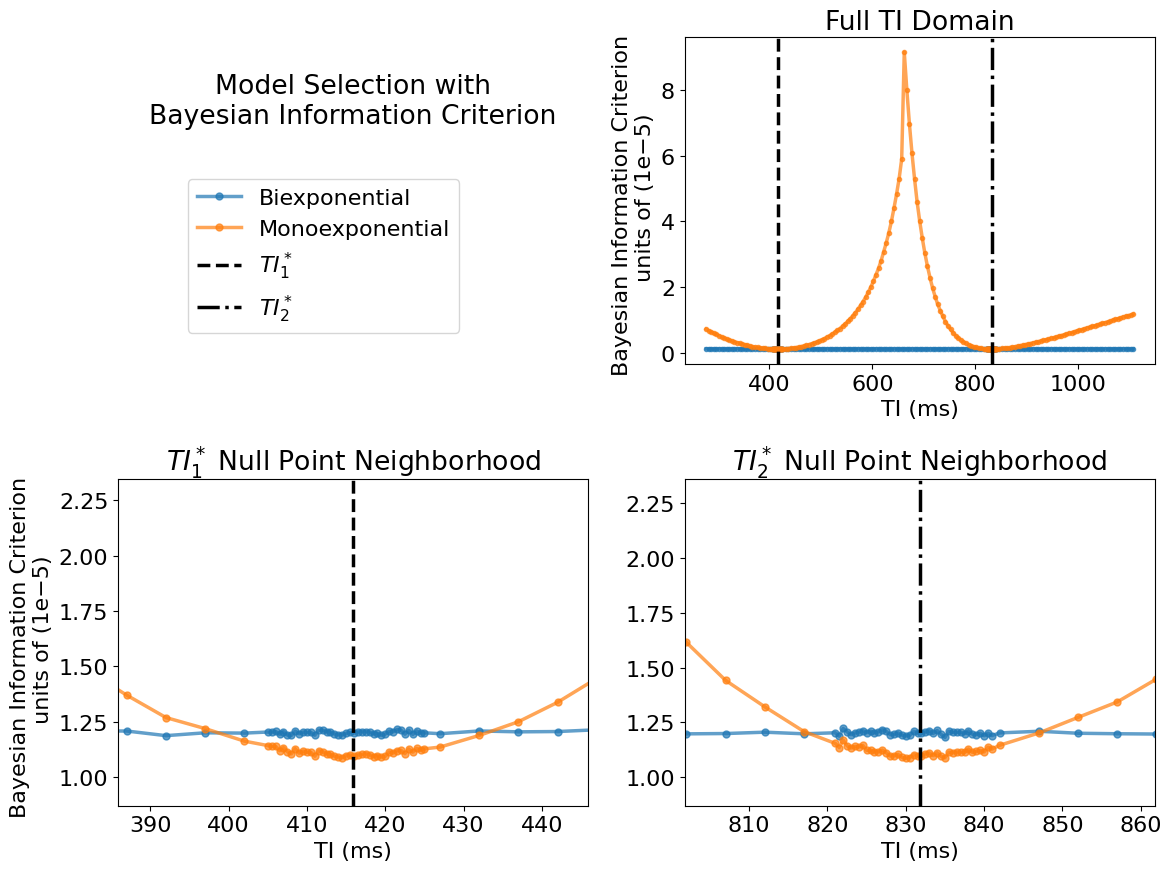

In [233]:
fig, ax = plt.subplots(2,2,figsize=(12,9), tight_layout=True)
# fig.suptitle('Null Point Neighbhorhood Bayes Information Criterion')

plt.rc('font', size = 16)

minVal_1E = min(BIC_1E[0: np.size(BIC_1E)//2])
minVal_2E = min(BIC_2E[0: np.size(BIC_2E)//2])
min_meas = min([minVal_1E,minVal_2E])
max_meas = max([minVal_1E,minVal_2E])


ax[1,0].plot(TI_array, BIC_2E, label = 'Biexponential', alpha = 0.7, marker = 'o', lw = 2.5, ms = 5)
ax[1,0].plot(TI_array, BIC_1E, label = 'Monoexponential', alpha = 0.7, marker = 'o', lw = 2.5, ms = 5)
ax[1,0].set_title(r'$TI^*_1$ Null Point Neighborhood')
ax[1,0].axvline(x=TI1star, label= r'$TI^*_1$', color='k', ls = '--', lw = 2.5)
ax[1,0].set_xlabel('TI (ms)')
ax[1,0].figure.canvas.draw()
offset = ax[1,0].yaxis.get_major_formatter().get_offset()
ax[1,0].yaxis.offsetText.set_visible(False)
ax[1,0].yaxis.set_label_text('Bayesian Information Criterion \n units of (' + offset + ')')
ax[1,0].set_ylim([0.8*min_meas,2*max_meas])
ax[1,0].set_xlim([TI1star-2*rad, TI1star+2*rad])



handler_TI1, labeler_TI1 = ax[1,0].get_legend_handles_labels()

minVal_1E = min(BIC_1E[np.size(BIC_1E)//2:])
minVal_2E = min(BIC_2E[np.size(BIC_2E)//2:])
min_meas = min([minVal_1E,minVal_2E])
max_meas = max([minVal_1E,minVal_2E])

ax[1,1].plot(TI_array, BIC_2E, alpha = 0.7, marker = 'o', lw = 2.5, ms = 5)
ax[1,1].plot(TI_array, BIC_1E, alpha = 0.7, marker = 'o', lw = 2.5, ms = 5)
ax[1,1].set_title(r'$TI^*_2$ Null Point Neighborhood')
ax[1,1].axvline(x=TI2star, label= r'$TI^*_2$', color='k', ls = '-.', lw = 2.5)
ax[1,1].set_xlabel('TI (ms)')
ax[1,1].figure.canvas.draw()
offset = ax[1,1].yaxis.get_major_formatter().get_offset()
ax[1,1].yaxis.offsetText.set_visible(False)
# ax[1,1].yaxis.set_label_text('Bayesian Information Criterion \n units of (' + offset + ')')
ax[1,1].set_ylim([0.8*min_meas,2*max_meas])
ax[1,1].set_xlim([TI2star-2*rad, TI2star+2*rad])

handler_TI2, labeler_TI2 = ax[1,1].get_legend_handles_labels()

hd = [handler_TI1[0], handler_TI1[1], handler_TI1[2], handler_TI2[0]]
lab = [labeler_TI1[0], labeler_TI1[1], labeler_TI1[2], labeler_TI2[0]]


ax[0,0].axis('off')
ax[0,0].legend(hd, lab, bbox_to_anchor = [0.75,0.6])
ax[0,0].set_title('Model Selection with\nBayesian Information Criterion', y=0.8, pad=-15)

ax[0,1].plot(TI_array, BIC_2E, alpha = 0.7, marker = 'o', lw = 2.5, ms = 3)
ax[0,1].plot(TI_array, BIC_1E, alpha = 0.7, marker = 'o', lw = 2.5, ms = 3)
ax[0,1].axvline(x=TI1star, color='k', ls = '--', lw = 2.5)
ax[0,1].axvline(x=TI2star, color='k', ls = '-.', lw = 2.5)
ax[0,1].set_xlabel('TI (ms)')
ax[0,1].figure.canvas.draw()
offset = ax[0,1].yaxis.get_major_formatter().get_offset()
ax[0,1].yaxis.offsetText.set_visible(False)
ax[0,1].yaxis.set_label_text('Bayesian Information Criterion \n units of (' + offset + ')')
ax[0,1].set_title('Full TI Domain')

Text(0.5, 0.98, 'Model Selection with\nBayesian Information Criterion')

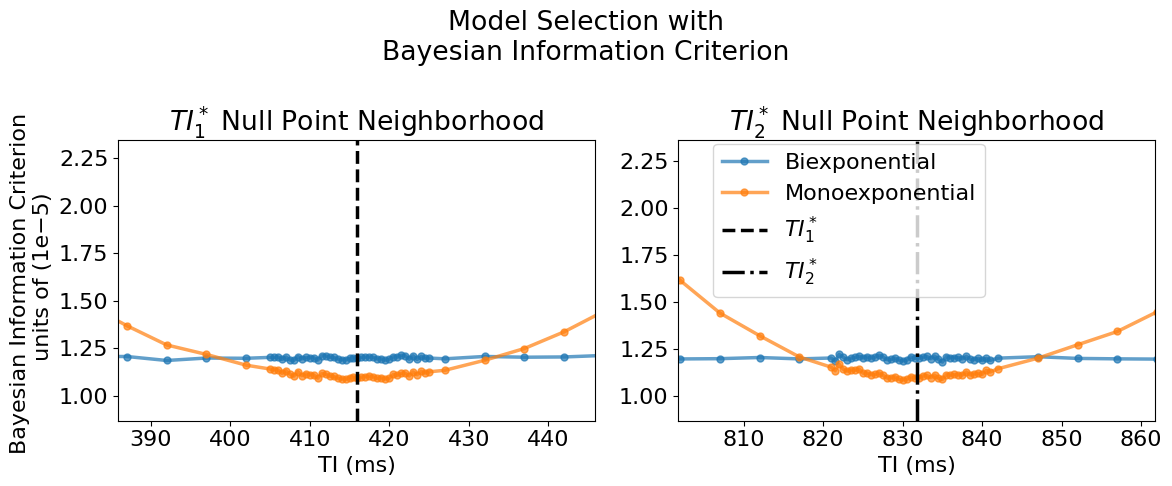

In [237]:
fig, ax = plt.subplots(1,2,figsize=(12,5), tight_layout=True)
# fig.suptitle('Null Point Neighbhorhood Bayes Information Criterion')

plt.rc('font', size = 16)

minVal_1E = min(BIC_1E[0: np.size(BIC_1E)//2])
minVal_2E = min(BIC_2E[0: np.size(BIC_2E)//2])
min_meas = min([minVal_1E,minVal_2E])
max_meas = max([minVal_1E,minVal_2E])


ax[0].plot(TI_array, BIC_2E, label = 'Biexponential', alpha = 0.7, marker = 'o', lw = 2.5, ms = 5)
ax[0].plot(TI_array, BIC_1E, label = 'Monoexponential', alpha = 0.7, marker = 'o', lw = 2.5, ms = 5)
ax[0].set_title(r'$TI^*_1$ Null Point Neighborhood')
ax[0].axvline(x=TI1star, label= r'$TI^*_1$', color='k', ls = '--', lw = 2.5)
ax[0].set_xlabel('TI (ms)')
ax[0].figure.canvas.draw()
offset = ax[0].yaxis.get_major_formatter().get_offset()
ax[0].yaxis.offsetText.set_visible(False)
ax[0].yaxis.set_label_text('Bayesian Information Criterion \n units of (' + offset + ')')
ax[0].set_ylim([0.8*min_meas,2*max_meas])
ax[0].set_xlim([TI1star-2*rad, TI1star+2*rad])



handler_TI1, labeler_TI1 = ax[0].get_legend_handles_labels()

minVal_1E = min(BIC_1E[np.size(BIC_1E)//2:])
minVal_2E = min(BIC_2E[np.size(BIC_2E)//2:])
min_meas = min([minVal_1E,minVal_2E])
max_meas = max([minVal_1E,minVal_2E])

ax[1].plot(TI_array, BIC_2E, alpha = 0.7, marker = 'o', lw = 2.5, ms = 5)
ax[1].plot(TI_array, BIC_1E, alpha = 0.7, marker = 'o', lw = 2.5, ms = 5)
ax[1].set_title(r'$TI^*_2$ Null Point Neighborhood')
ax[1].axvline(x=TI2star, label= r'$TI^*_2$', color='k', ls = '-.', lw = 2.5)
ax[1].set_xlabel('TI (ms)')
ax[1].figure.canvas.draw()
offset = ax[1].yaxis.get_major_formatter().get_offset()
ax[1].yaxis.offsetText.set_visible(False)
# ax[1,1].yaxis.set_label_text('Bayesian Information Criterion \n units of (' + offset + ')')
ax[1].set_ylim([0.8*min_meas,2*max_meas])
ax[1].set_xlim([TI2star-2*rad, TI2star+2*rad])

handler_TI2, labeler_TI2 = ax[1].get_legend_handles_labels()

hd = [handler_TI1[0], handler_TI1[1], handler_TI1[2], handler_TI2[0]]
lab = [labeler_TI1[0], labeler_TI1[1], labeler_TI1[2], labeler_TI2[0]]

ax[1].legend(hd, lab, bbox_to_anchor = [0.05,0.4])
fig.suptitle('Model Selection with\nBayesian Information Criterion')

### Rule-Breaking Plot

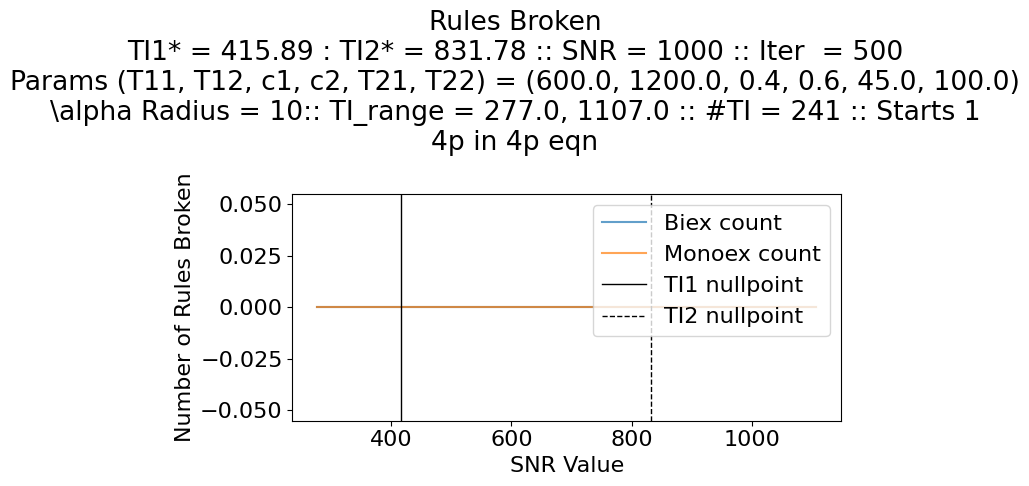

In [38]:
fig = plt.figure(figsize=(7,5), tight_layout=True)
fig.suptitle('Rules Broken' + details)
plt.plot(TI_array, numRuleBreak[:,0], label= 'Biex count', alpha = 0.7)
plt.plot(TI_array, numRuleBreak[:,1], label= 'Monoex count', alpha = 0.7)
plt.axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
if bothTI:
    plt.axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
plt.xlabel('SNR Value')
plt.ylabel('Number of Rules Broken')
# plt.title('Biexponential Model')
plt.legend()
plt.show()

### Sensitivity Plots

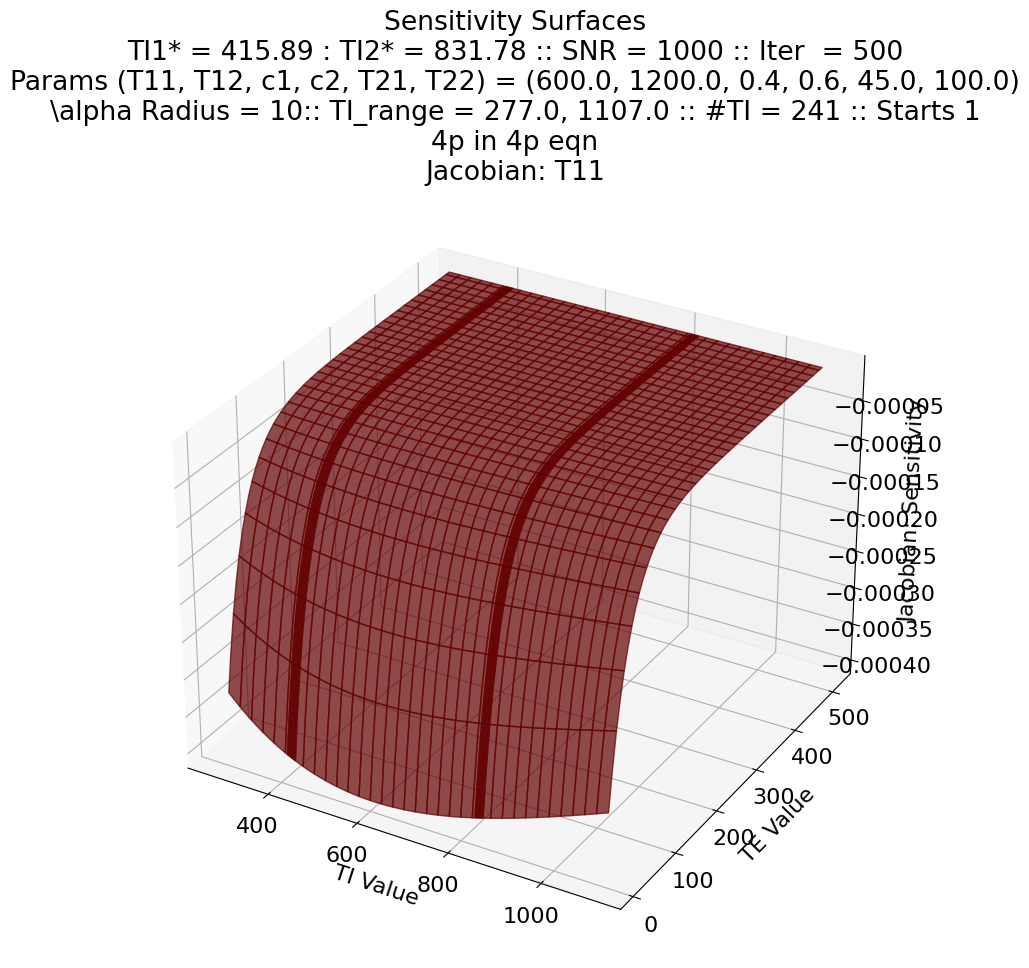

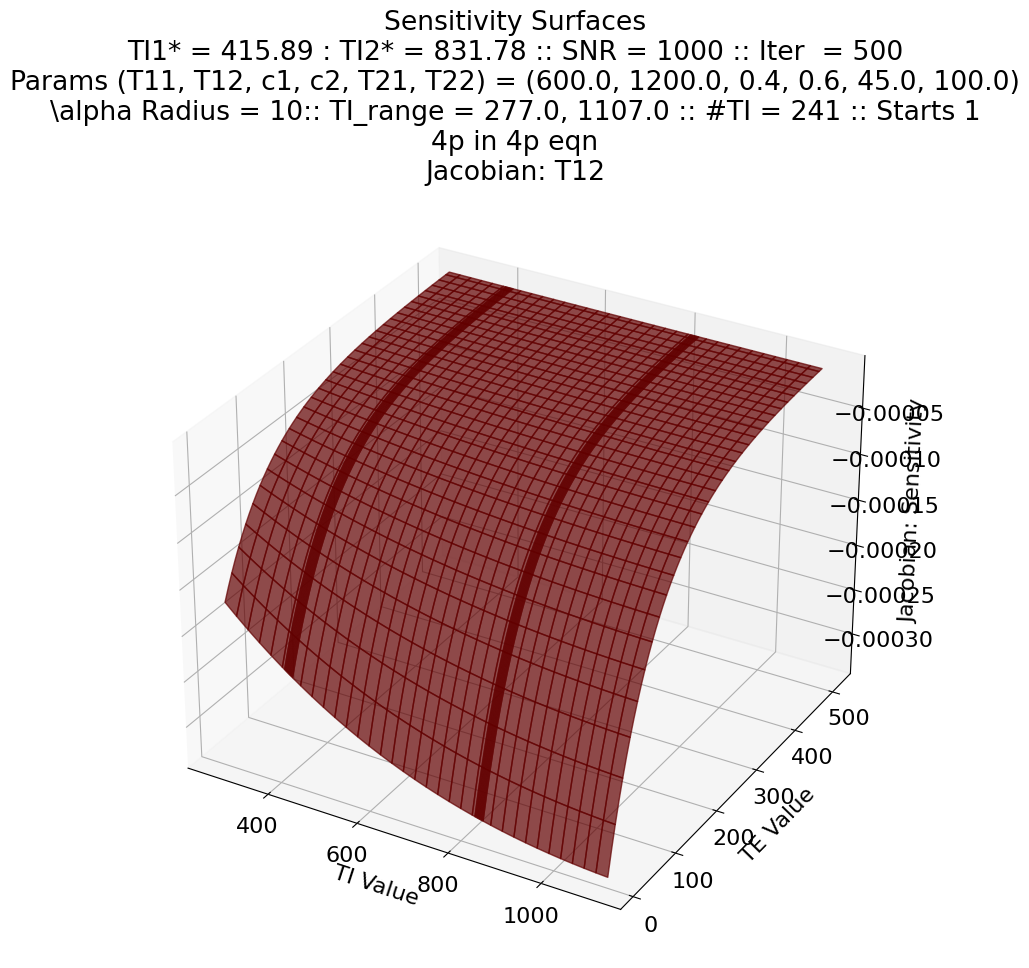

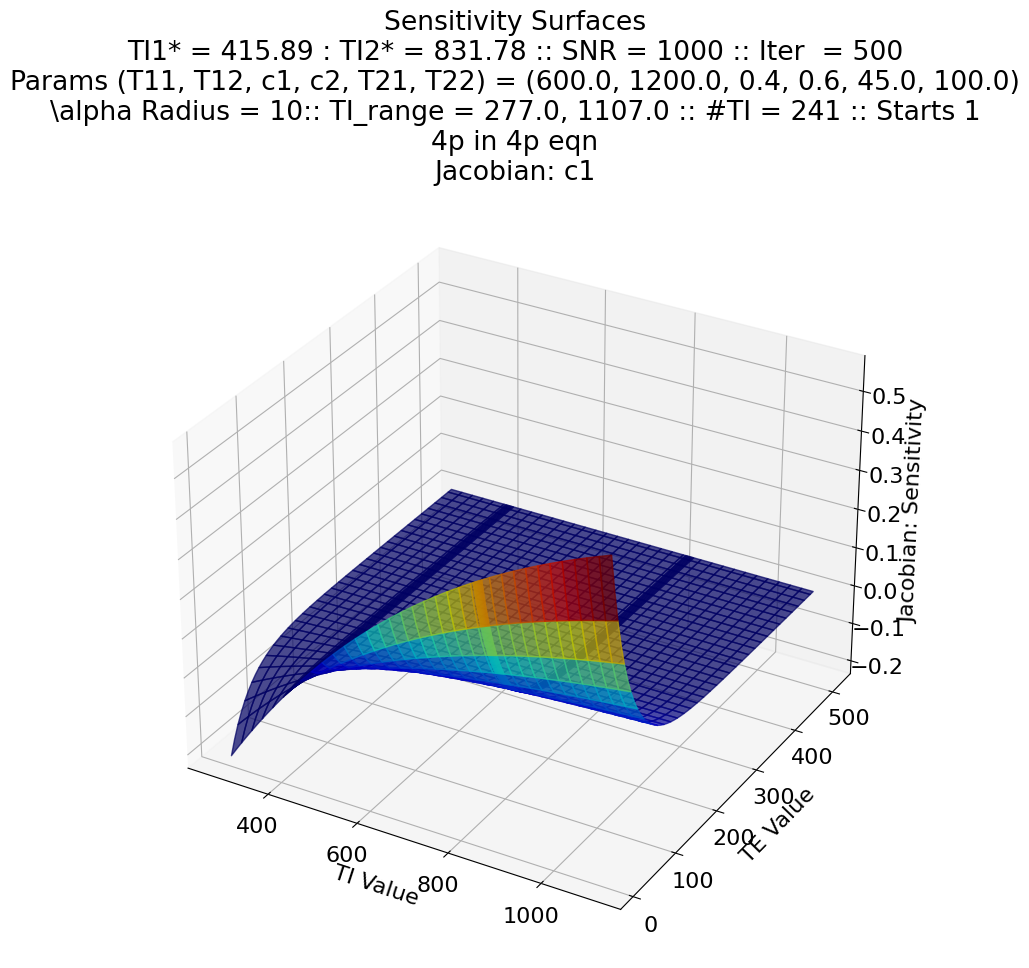

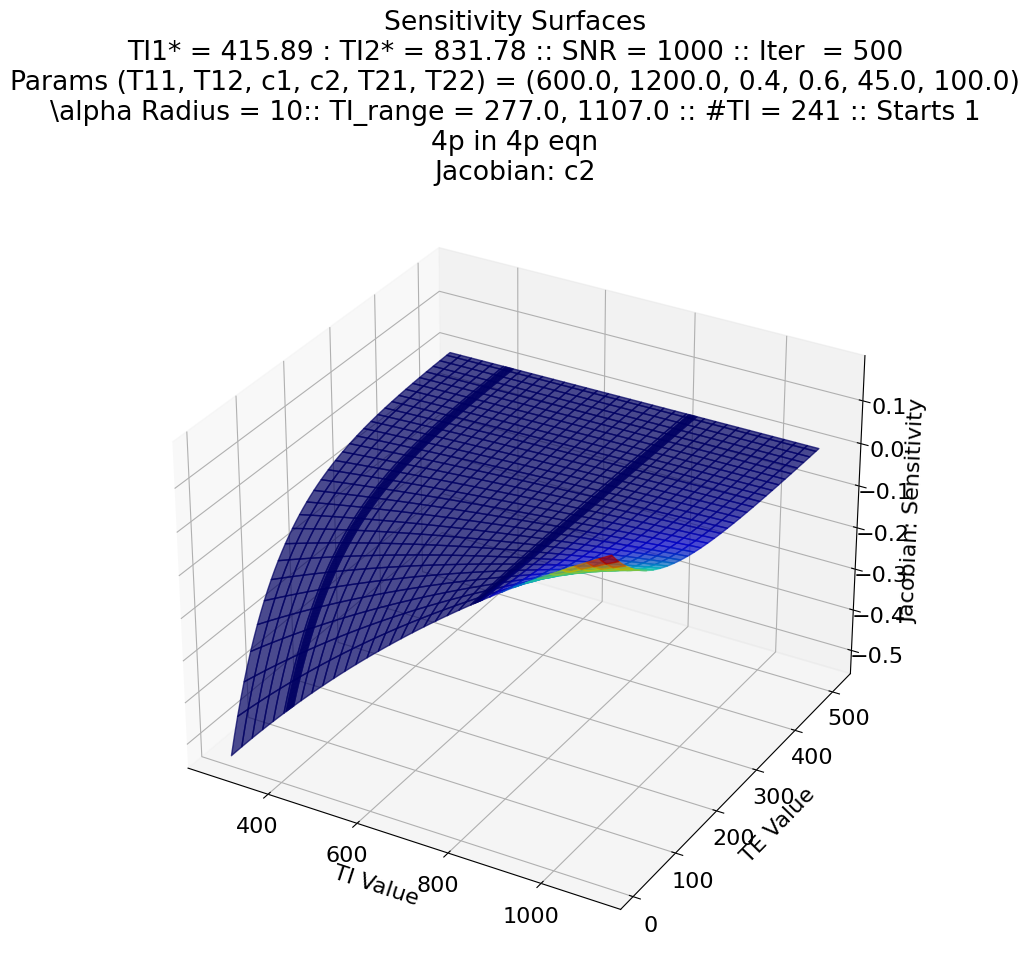

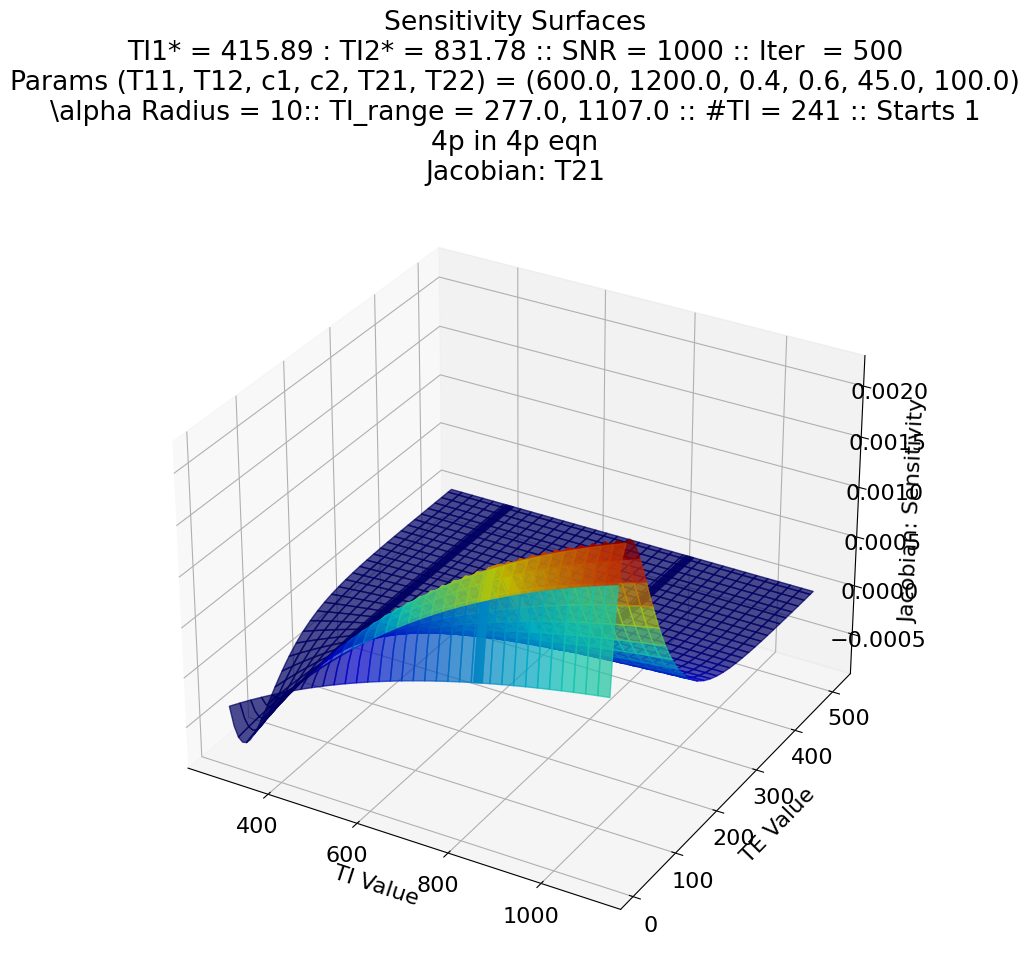

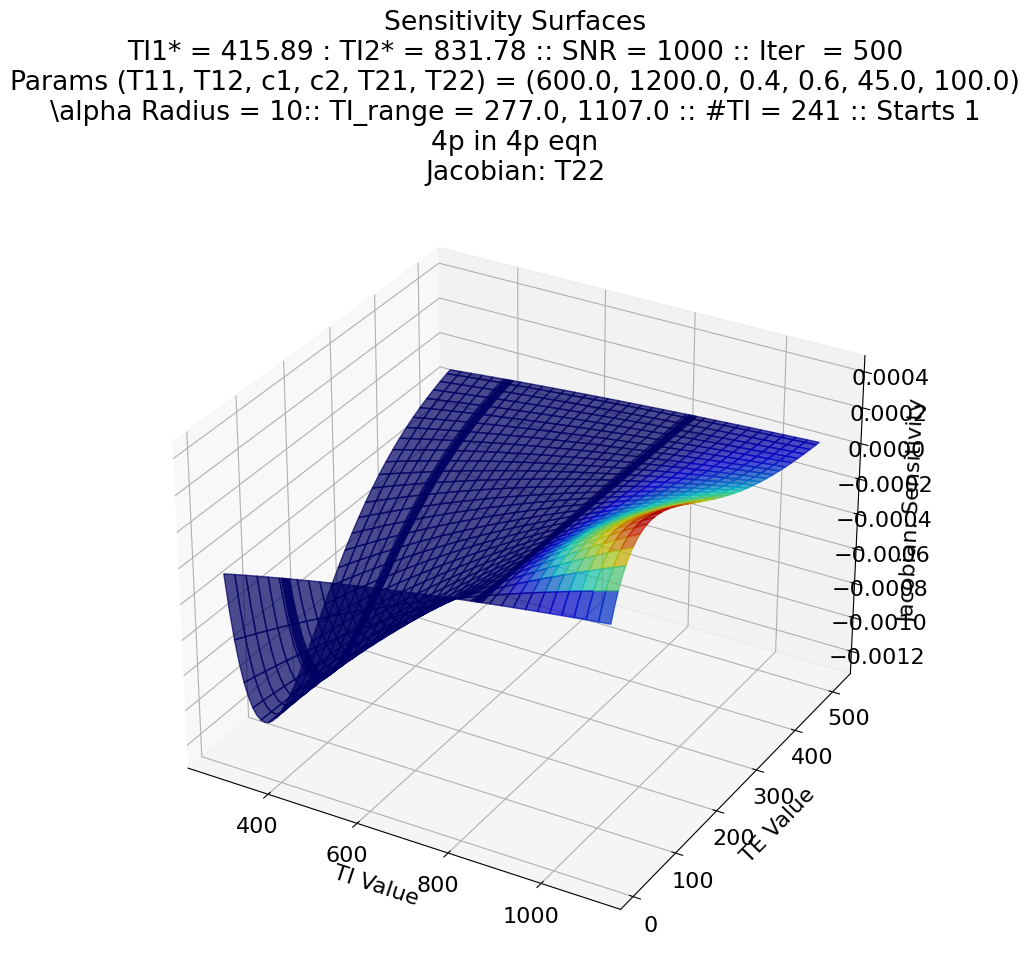

<Figure size 640x480 with 0 Axes>

In [39]:
dModel = False
TImg,TEmg = np.meshgrid(TI_array,TE_series)
avgPStore = np.mean(paramStore_2E, axis = 1)
if dModel:
    Jstore = np.zeros((TImg.shape[0],TImg.shape[1],np.size(ParamTitle_4p)))
else:
    Jstore = np.zeros((TImg.shape[0],TImg.shape[1],np.size(ParamTitle_6p)))
for i in range(Jstore.shape[0]):
    for j in range(Jstore.shape[1]):
        if dModel:
            TI = TImg[i,j]
            d1 = d_value(TI,c1,T11)
            d2 = d_value(TI,c2,T12)
            Jstore[i,j,:] = Jacobian_4p(TEmg[i,j], d1, d2, T21, T22)
        else:
            Jstore[i,j,:] = Jacobian_6p(TEmg[i,j],TImg[i,j],T11,T12,c1,c2,T21,T22)
        
JacobianTitles = ["T11","T12","c1","c2","T21","T22"]


for j in range(Jstore.shape[2]):
    fig = plt.figure(figsize = (10,10))
    ax = plt.axes(projection='3d')
    my_col = cm.jet(Jstore[:,:,j]/np.amax(Jstore[:,:,j]))
    ax.plot_surface(TImg,TEmg,Jstore[:,:,j], alpha = 0.7, facecolors = my_col)
    ax.set_xlabel('TI Value')
    ax.set_ylabel('TE Value')
    ax.set_zlabel('Jacobian: Sensitivity')
    if dModel:
        ax.set_title('Sensitivity Surfaces' + details + '\nJacobian: ' + ParamTitle_4p[j])
    else:
        ax.set_title('Sensitivity Surfaces' + details + '\nJacobian: ' + JacobianTitles[j])
    plt.show()



plt.tight_layout()
plt.show()